# NFL Sports Analytics

<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools</div>




<br />
<left>
<img src="ipynb.images/cam-newton.jpg" width=600 />
</left>

I think many professors teach data science *ineffectively*. They teach the math and the algorithms, but they fail to showcase the *sexiness* of the subject matter.

So I thought, what is going on right now in America that is intersting and sexy to do data science with? We did covid19 with my class last semester, so I don't want to do that again. Plus, enough with that and hooray for vaccines.

So I though it's football season in America, and in American all companies have *football pools to predict *winners* and game *point spreads*. 

So, for your final project, please do *data science* and build a model that predicts who will win :-)

Now, because your instructor is such a kind-hearted individual, he won't just stop here. He will also give you hints. In fact, he'll give you a pretty good **iterative** bayesian *baseline model*, and your assignment will be to *improve* it. I'll also give you four suggestions for how I would try to improve it, but you are not forced to follow them.
<left>
<img src="ipynb.images/kind-hearted-teacher.gif" width=300 />
</left>

According to [NFL Pickwatch](http://nflpickwatch.com/), best pickers predict 68 or 69%

Typically, pickers run linear regressions to predict point spread, and logistic regressions to predict win probability, given various team and player data. 

[Arpad Elo](https://en.wikipedia.org/wiki/Arpad_Elo) was a Hungarian-American physics professor who invented a system to rank chess players. Nate Silver adapted it for football, baseball, and sports on a Web site called [FiveThirtyEight](https://fivethirtyeight.com/features/how-our-2017-nfl-predictions-work/), also famous for presidential predictions.

Nate Silver's [NFL Elo rankings](https://fivethirtyeight.com/tag/nfl-elo-ratings/) are famous, achieving 60% accuracy out of literally no information but home field advantage and past scores. 

They update weekly to incorporate new information, so this is Bayesian statistics territory.

Silver's Elo model maintains a running metric of team ability, $Elo_{tm}$, that updates after every game. The [formula](https://fivethirtyeight.com/features/introducing-nfl-elo-ratings) and the [source code](https://github.com/fivethirtyeight/nfl-elo-game/blob/master/forecast.py) are famous. The number is used to estimate win probability of team $A$ playing team $B$ in almost the same way as you'd use the result from a logistic regression:

$$
Pr(\text{team A wins}) = \frac{1}{10^{-(Elo_A - Elo_B)/400} + 1}
$$

The FiveThirtyEight Elo approach is intuitive and simple:

1. Start with a baseline value for team skill
2. Update the Elo numbers every week
3. At the end of each season revert the values back to the mean

# 1. Iterative Bayesian Modeling
Let's do something more data science-y and use a *mathematical* model. Remember there's 3 approaches to data science:
- Classical math, with the disadvantage of inherited bias
- In-between math and computer science, which is what we did in this class this semester: Postulate a math model from the histogram, then find its parameters with computer simulation
- Pure computer science, i.e. Machine Learning, what you might want to study *after* this class, where you use linear algebra and graphs to interpolate point clouds into high-dimensional manifolds (surfaces) in order to predict missing datapoints

>**Note**: And no, you're not allowed to jump straight to ML at HGEN without going through *me* first, so I can teach you the good and the bad about the math, and the foundations of ML so that ML will be *so much easier* now ;-)

We'll use [exponential models](https://en.wikipedia.org/wiki/Exponential_family), which is what we used in class so far. 

Exponential modelas have a great advantage, which I used but did not really explain at depth: They have well-defined [conjugate prior distributions](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions), which enable closed-form solutions for the posterior distribution in Bayes' formula.

For example, here's a [computation](https://en.wikipedia.org/wiki/Conjugate_prior#Example) that reveals that if you start with a [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) prior, it can be proved analytically with *math* that its posterior is a [Beta-distribution](https://en.wikipedia.org/wiki/Beta_distribution), and all subsequent posteriors are also Betas.

This was *very important* in the 1800s and 1900s, because they did not have computers back then! But we do today, so we can just model numerically. However, if we have the formulas, why not reuse them?

In fact, we'll use a [Beta-distribution](https://en.wikipedia.org/wiki/Beta_distribution) to predict win probability, and a [Student-T](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for estimating point spread.


# Data

FiveThirtyEight's [github](https://github.com/fivethirtyeight/nfl-elo-game) contains a dataset of historical scores that date back to 1920. The column `neutral` has two values: `neutral == 1` means the game is on neutral ground (no home field advantage), and `neutral == 0` means the home field advantage goes to `team1`. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # at least 0.19.2 to read_csv from url
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict

sns.set_context("notebook")
sns.set_style("white")

url = "https://github.com/fivethirtyeight/nfl-elo-game/raw/master/data/nfl_games.csv"
df = pd.read_csv(url)
print(df.shape)
df.head(5)

(16274, 12)


date  season  neutral  playoff team1 team2      elo1      elo2  \
0  1920-09-26    1920        0        0   RII   STP  1503.947  1300.000   
1  1920-10-03    1920        0        0   AKR   WHE  1503.420  1300.000   
2  1920-10-03    1920        0        0   RCH   ABU  1503.420  1300.000   
3  1920-10-03    1920        0        0   DAY   COL  1493.002  1504.908   
4  1920-10-03    1920        0        0   RII   MUN  1516.108  1478.004   

   elo_prob1  score1  score2  result1  
0   0.824651      48       0      1.0  
1   0.824212      43       0      1.0  
2   0.824212      10       0      1.0  
3   0.575819      14       0      1.0  
4   0.644171      45       0      1.0

In [2]:
# First create the "spread" column
df['spread'] = df.score1 - df.score2

In [3]:
df.sample(10)

date  season  neutral  playoff team1 team2      elo1      elo2  \
13358  2008-09-14    2008        0        0    TB   ATL  1461.094  1418.099   
12625  2005-10-23    2005        0        0   LAR    NO  1449.579  1454.984   
7456   1984-09-30    1984        0        0   NYJ    NE  1528.027  1512.066   
4147   1967-12-10    1967        0        0   TEN   OAK  1488.291  1706.990   
8939   1990-12-02    1990        0        0   WSH   MIA  1541.933  1613.907   
6561   1980-09-07    1980        0        0   SEA   LAC  1532.664  1609.009   
14823  2013-11-17    2013        0        0    NO    SF  1615.884  1637.661   
5070   1972-12-03    1972        0        0   NYJ    NO  1504.503  1367.761   
5313   1974-09-15    1974        0        0   CIN   CLE  1570.979  1531.211   
6926   1981-11-08    1981        0        0   WSH   DET  1448.141  1488.496   

       elo_prob1  score1  score2  result1  spread  
13358   0.650598      24       9      1.0      15  
12625   0.584933      28      17      1.0      11  
7456    0.614448      21      28      0.0      -7  
4147    0.292192       7      19      0.0     -12  
8939    0.489965      42      20      1.0      22  
6561    0.483679      13      34      0.0     -21  
14823   0.561884      23      20      1.0       3  
5070    0.761573      18      17      1.0       1  
5313    0.646364      33       7      1.0      26  
6926    0.535408      33      31      1.0       2

# EDA
There are over 100 football teams total. If we cut off at 1980, we get the familiar 32 teams.

Is the point spread normally distributed?

Let's plot the histograms of each team's point spread at home since 1980. Each bar is 7 points wide, and a normal distribution is superimposed with a dashed line.

- A large number of games end with spreads that are within 1 touchdown (±7 points).
- The Browns (CLE), Lions (DET), Chargers (LAC), Rams (LAR), and Jets (NYJ) often lose by 1 touchdown or less.
- The Cardinals (ARI), Broncos (DEN), Dolphins (MIA), Patriots (NE), and Seahawks (SEA)
  often win by 1 touchdown or less.
  
The histograms below should remind you of our Celtics' histogram, and reflect the famous theorem that given sufficiently large number of independent events, the histogram will be normally distributed.

Total teams in the dataset: 101
Total teams after 1980: 32


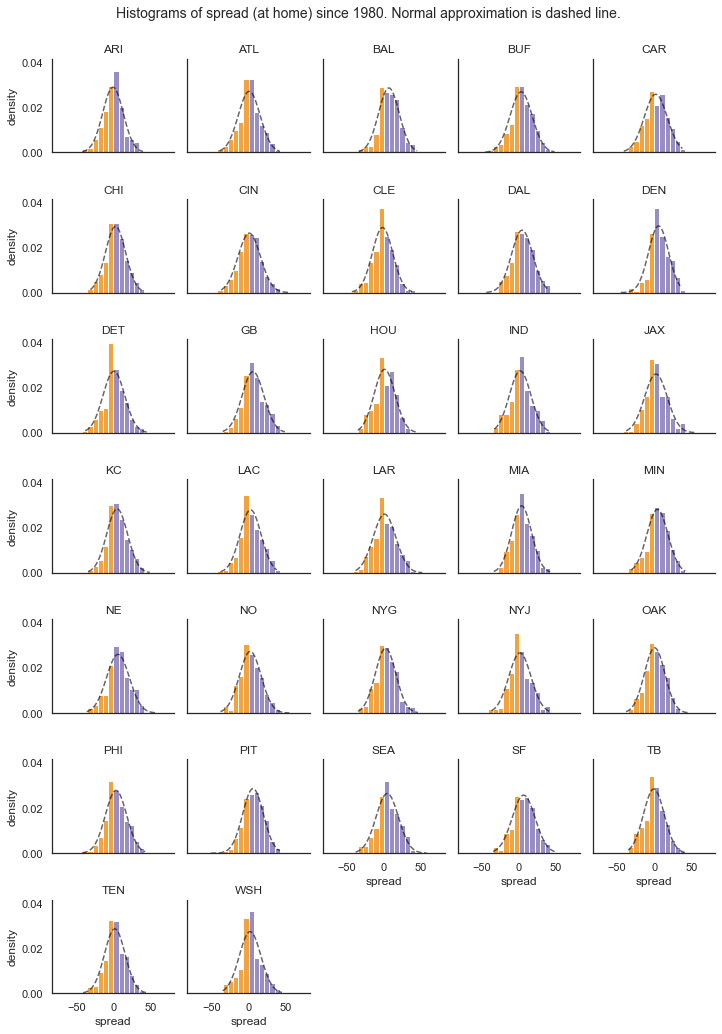

In [4]:
print("Total teams in the dataset:", len(df.team1.unique()))
print("Total teams after 1980:", len(df[df.season > 1980].team1.unique()))


def color_coded_hist(x, **kwargs):
    """Color the negative and positive bins differently.

    Color scheme from http://colorbrewer2.org/    
    """
    hist_bins = [-75, -42, -35, -28, -21, -14, -7, 0, 7, 14, 21, 28, 35, 42, 75]
    __, __, patches = plt.hist(x, density=True, bins=hist_bins, color="#f1a340")
    # Purple for positive spread:
    i = next(i for i, val in enumerate(hist_bins) if val == 0)
    for p in patches[i:]:
        p.set_facecolor("#998ec3")
        

def best_norm(x, **kwargs):
    """Plot the best normal fit for the data."""
    mu, std = stats.norm.fit(x)
    # Plot the PDF.
    xmin, xmax = min(x), max(x)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', alpha=0.6)


# since 1980
g = sns.FacetGrid(df[df.season > 1980].sort_values('team1'), col="team1", col_wrap=5, height=2)
g = (g.map(color_coded_hist, "spread")
     .map(best_norm, "spread")
     .set_titles("{col_name}")
     .set_axis_labels("spread", "density"))
msg = "Histograms of spread (at home) since 1980. Normal approximation is dashed line."
plt.suptitle(msg, y=1.025, fontsize=14);

Nate Silver's model bumps the team's Elo rating by a constant to account for home field advantage. 

Let's model home field advantage as the average from the past three seasons, rather than the average since 1980.

Let's plot point spread and win percentage, year over year. The approximation for home advantage is a dotted black line. The central tendency for the data is a solid blue line, and the 95% confidence interval for each season is the light blue region. 

* Starting around the 1970's the overall point spread tightens: H home field advantage starts at 10 points on average in 1920 and settles down to 2 to 3 points per game, give or take a couple of points
* This translates to about a 16% greater chance of winning at home (58% at home versus 42% away)
* Approximating home field advantage via the average of the past three years (black dotted line) looks fine: It closely tracks the actual median and is always within the confidence interval

~ Overall ~
spread     2.965903
result1    0.580610
dtype: float64

~ Past few seasons ~
          spread   result1
season                    
2012    2.615094  0.575472
2013    3.174242  0.600379
2014    2.851711  0.583650
2015    1.475285  0.539924
2016    3.057252  0.585878
2017    2.639847  0.574713
2018    2.319392  0.600760


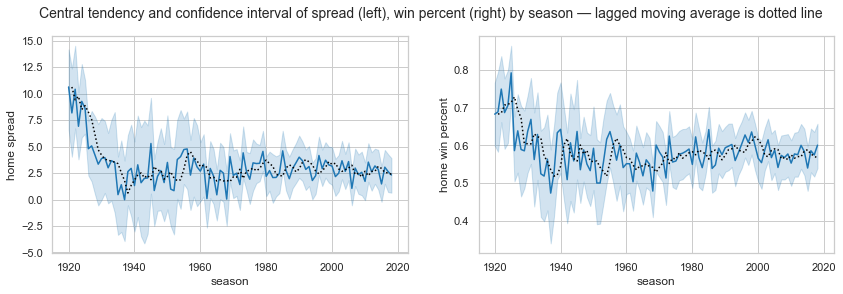

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Show some of the values
print("~ Overall ~")
print(df[df.neutral == 0][['spread', 'result1']].mean())
print("\n~ Past few seasons ~")
print(df[(df.neutral == 0) & (df.season > 2011)].groupby('season')[['spread', 'result1']].mean())

# Create a data frame with lagged rolling means and combine with the existing data
rolling_avg = (
    df.groupby('season')[['spread', 'result1']].mean()
    .rolling(3, min_periods=1)
    .mean()
    .shift(1)
)
rolling_avg['win_pct_advantage'] =  rolling_avg.result1 - .5
rolling_avg['spread_advantage'] = rolling_avg.spread
rolling_avg = rolling_avg.drop(columns=['result1', 'spread'])


# Plot everything
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14.0, 4.0)
f, ax = plt.subplots(1, 2)
sns.lineplot(x="season", y="spread", data=df[df.neutral == 0], ax=ax[0])
ax[0].plot(rolling_avg.index, rolling_avg.spread_advantage, 'k:')
ax[0].set_ylabel("home spread")

sns.lineplot(x="season", y="result1", data=df[df.neutral == 0], ax=ax[1])
ax[1].plot(rolling_avg.index, rolling_avg.win_pct_advantage + .5, 'k:')
ax[1].set_ylabel("home win percent")
plt.suptitle(
    'Central tendency and confidence interval of spread (left), '
    'win percent (right) by season — lagged moving average is dotted line',
    fontsize=14);

The dataset has one row per game (*by-game* format), with the home team labelled as `team1`.

If we want to see all of the games for a single team, we need to reshape the dataset to *by-team* format, meaning there are two rows per game, adding an extra column `home` to identify the home team, so we can group by *season*.


<div style="display:flex;justify-content:center;align-items:center;">
    <table>
        <caption>by-game format: one row per game</caption>
        <tr><th>season</th><th>date</th><th>team1</th><th>team2</th><th>result1</th></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>CHI</td><td>NE</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>MIN</td><td>CHI</td><td>0</td></tr>
    </table>
    ⇨
    <table>
        <caption>by-team format: one row per team per game</caption>
        <tr><th>season</th><th>date</th><th>home</th><th>team1</th><th>team2</th><th>result1</th></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>1</td><td>CHI</td><td>NE</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>0</td><td>CHI</td><td>MIN</td><td>1</td></tr>
        <tr><td>1985</td><td>1985-09-15</td><td>0</td><td>NE</td><td>CHI</td><td>0</td></tr>
        <tr><td>1985</td><td>1985-09-19</td><td>1</td><td>MIN</td><td>CHI</td><td>0</td></tr>
    </table>
</div>

In [16]:
home_games = df[[
    'date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'result1', 'spread'
]][df.season > 1975]
home_games['home'] = 1

# Now swap the teams for "away"
away_games = home_games.rename(columns={'team1':'team2', 'team2':'team1'})
away_games['home'] = 1 - home_games.home
# Remember to switch the meaning of the winning and spread columns too
away_games['result1'] = 1 - home_games.result1
away_games['spread'] = - home_games.spread

by_team = (
    pd.concat([home_games, away_games], ignore_index=True)
    .sort_values(by=['season', 'team1', 'date'])
)
by_team.head(10)

date  season  neutral  playoff team1 team2  result1  spread  home
10595  1976-09-12    1976        0        0   ARI   SEA      1.0       6     0
24     1976-09-19    1976        0        0   ARI    GB      1.0      29     1
10621  1976-09-26    1976        0        0   ARI   LAC      0.0     -19     0
48     1976-10-03    1976        0        0   ARI   NYG      1.0       6     1
58     1976-10-10    1976        0        0   ARI   PHI      1.0      19     1
73     1976-10-17    1976        0        0   ARI   DAL      1.0       4     1
10688  1976-10-25    1976        0        0   ARI   WSH      0.0     -10     0
107    1976-10-31    1976        0        0   ARI    SF      1.0       3     1
10706  1976-11-07    1976        0        0   ARI   PHI      1.0       3     0
10725  1976-11-14    1976        0        0   ARI   LAR      1.0       2     0

In [17]:
by_team.shape

(21182, 9)

# Bayesian model for winning prediction

Both our models will follow the same *iterative Bayesian* procedure:

1. Initialize the model with a baseline:
    1. Beta win probability = 50%
    2. Student-T spread = 0
2. After every game, update hyperparameters with the new information as described in their respective formulas
3. Use hyperparameters to calculate the posterior from the prior, using Bayes, evaluating posteriors from last game's priors.The posterior is the distribution that is found *a posteriori*, meaning after you combine your prior knowledge and the likelihood of the observed data using Bayes's theorem:

$$p(\theta | x) = \frac{p(x|\theta) p(\theta)}{p(x)}$$
  
`abc` stands for `a`bstract `b`ase `c`lass:
```(python)
pip install abcplus
```

We'll use it to define an abstract python class, which we'll *specialize* to different models, one for predicting wins, the other for predicting point spread:

In [7]:
from abc import ABC, abstractmethod
from collections import namedtuple

class Updater(ABC):
    def __init__(self, *hyperparameters):
        # Form of lookup:
        # {season: {team: [{week1 data}, {week2 data}, ... {weekN data}]}}
        self.lookup = {}
        #self.Params = {'Params': ['date'] + list(hyperparameters)}
        # we use a named tuple so we can actually call it. A dict is not callable
        self.Params = namedtuple('Params', ['date'] + list(hyperparameters))
        
    def iterrows(self):
        for season, teams in self.lookup.items():
            for team, results in teams.items():
                for row in results:
                    yield dict(season=season, team1=team, **row._asdict())
        
    def get_rows(self):
        return [r for r in self.iterrows()]
    
    # run at the beginning of every season
    @abstractmethod
    def revert_to_mean(self, season, team, keep=.3, n_obs=8):
        pass
    
    @abstractmethod
    def update(self, row):
        pass

# Beta distribution

The [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), conjugate prior of the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution), is parameterized by two positive shape parameters, α and β, that appear as exponents of the random variable and control the shape of the distribution (the generalization from univariate to multivariate is called the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)).

Let's talk a bit more about the Beta.

The beta distribution is even more important in baseball, to predict *percentages*. 

</br >
<center>
<img src="ipynb.images/atbat.png" width=400 />
</center>

Whereas the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is a *count* statistic (remember, we used it spy on my girlfriend's *texts*), the Beta distribution can be thought of as representing a distribution of *probabilities*- that is, it represents all the possible values of a probability when we don't know what that probability is. 

The domain of the Beta distribution is (0, 1), just like a probability, so we already know we're on the right track.

Imagine you want to predict a baseball player's season-long batting averagee.  We know it's somewhere around the float number .300, like we know the average integer number of text phones I can expect my girlfriend to receive per day before I get worried too much.

The baseball player can get into a lucky streak and get an average of 1.000, or an unlucky streak with an average of 0, neither of which are a good predictor. Let's go in with prior expectations: In history, most season batting averages have hovered between something like .200 and .350, and update to a posterior.

Let's plot a Beta distribution with parameters α=81 and β=219. The mean is (by analytic derivation):

$$ \frac{\alpha}{\alpha + \beta} = \frac{81}{81+219} =.270$$

and the distribution lies almost entirely within the reasonable range for a batting average \[.2, .35\].

(array([  1.,   1.,   2.,   6.,   6.,  20.,  27.,  41.,  78.,  73.,  77.,
        110., 106.,  87., 109.,  91.,  58.,  41.,  32.,  15.,  11.,   7.,
          1.]),
 array([0.18237737, 0.18944409, 0.19651082, 0.20357755, 0.21064427,
        0.217711  , 0.22477773, 0.23184445, 0.23891118, 0.2459779 ,
        0.25304463, 0.26011136, 0.26717808, 0.27424481, 0.28131153,
        0.28837826, 0.29544499, 0.30251171, 0.30957844, 0.31664516,
        0.32371189, 0.33077862, 0.33784534, 0.34491207]),
 <BarContainer object of 23 artists>)

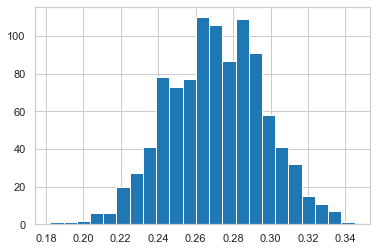

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

data = stats.beta.rvs(81, 219, loc = 0, scale = 1, size=1000)
plt.hist(data,bins='auto')

Imagine now the player gets his first at bat and has a single hit. His record for the season is now 1 hit; 1 at bat. 

We update our probabilities by shifting the entire curve over just a bit to reflect our new information. The new Beta distribution will be:

$$ \text{Beta}(\alpha_0 + \text{hits}, \beta_0 + \text{misses})$$
 
Where $α_0$ and $β_0$ are the parameters we started with: 81 and 219. Thus, in this case, $α$ has increased by 1 (his one hit), while $β$ has not increased at all (no misses yet). Read [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example) for proof. It's about *conjugate priors*.

Suppose halfway through the season he has been up to bat 300 times, hitting 150 out of those times. Let's plot!

(array([  1.,   2.,   3.,   5.,  13.,  13.,  34.,  51.,  62.,  82.,  93.,
         88., 118., 101.,  80.,  66.,  59.,  41.,  43.,  16.,   9.,   7.,
          6.,   6.,   1.]),
 array([0.32018084, 0.3253066 , 0.33043236, 0.33555812, 0.34068388,
        0.34580964, 0.35093541, 0.35606117, 0.36118693, 0.36631269,
        0.37143845, 0.37656421, 0.38168997, 0.38681573, 0.39194149,
        0.39706726, 0.40219302, 0.40731878, 0.41244454, 0.4175703 ,
        0.42269606, 0.42782182, 0.43294758, 0.43807335, 0.44319911,
        0.44832487]),
 <BarContainer object of 25 artists>)

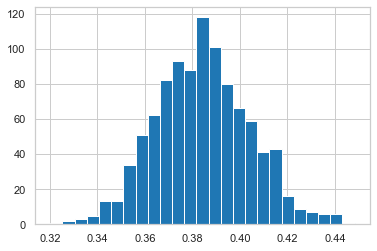

In [11]:
%matplotlib inline

data = stats.beta.rvs(81 + 150, 219 + 150, loc = 0, scale = 1, size=1000)
plt.hist(data,bins='auto')

Notice the curve is now both *thinner* (0.44 - 0.34 = 0.10 versus 0.34 - 0.20 = 0.14) and *shifted* to the right (higher batting average) than it used to be: We have a better sense of what the player's batting average is!

The Beta distribution is best for representing a probabilistic distribution of probabilities- the case where we don't know what a probability is in advance, but we have reasonable guesses.

And the numbers of wins and the number of losses let us update our model, so that with every new game, it becomes more "refined* and *precise*.

# Winning probability
So the mean of the probability of winning, using a Beta distribution with $\alpha$ and $\beta$ hyperparameters, is:

$$ \text{Pr}(\text{win}) = \frac{\alpha}{\alpha + \beta} \pm \text{home advantage} $$

The hyperparameters for the Beta distribution can be evaluated from empirical data:

$$
\begin{aligned}
  \alpha &= 1 + \text{number of wins}  \\
  \beta &=  1 + \text{number of losses}
\end{aligned}
$$

If we evaluate posteriors after every game, we update our hyperparameters with this rule:

* Win increments $\alpha$ by 1
* Loss increments $\beta$ by 1
* Tie increments both $\alpha$ and $\beta$ by 0.5

The default initial value sets $\alpha = \beta$, where you can choose how many **observations** (`n_obs`) to pretend we have already seen. If `n_obs` is a large number, then the incremental effect of new games won't be as pronounced. If `n_obs` is a small number, then the new season's data will quickly overwhelm the past performance. So, at the beginning of each season:

* Weigh $\alpha$ and $\beta$ at the beginning of each year as if they count for 4 games.
* Revert $\alpha$ and $\beta$ back to the mean ($\alpha = \beta$) keeping 80% of last year's final value.

In [12]:
class BetaUpdater(Updater):
    def __init__(self):
        super().__init__('alpha1', 'beta1')
        
    def revert_to_mean(self, season, team, keep=.8, n_obs=4):
        # default
        alpha = beta = 1 + n_obs * .5
        
        # or use existing data        
        if season in self.lookup and team in self.lookup[season]:
            last_entry = self.lookup[season][team].pop()
            date, alpha0, beta0 = last_entry
            p = alpha0 / (alpha0 + beta0)
            alpha = 1 + n_obs * (keep * p + (1 - keep) * .5)
            beta = 1 + n_obs * (keep * (1 - p) + (1 - keep) * .5)
            # push back the reverted value to the list
            self.lookup[season][team].append(self.Params(date, alpha, beta))
            
        return alpha, beta
            
    def update(self, row):
        if row.season not in self.lookup:
            self.lookup[row.season] = {}
        if row.team1 not in self.lookup[row.season]:
            self.lookup[row.season][row.team1] = []
            alpha, beta = self.revert_to_mean(row.season - 1, row.team1)
        else:
            __, alpha, beta = self.lookup[row.season][row.team1][-1]
            
        # THE UPDATE STEP:
        # a' = a + 1 if win else 0
        # b' = b + 1 if lose
        if row.result1 == 1:  # Won
            alpha_beta_next = self.Params(row.date, alpha + 1, beta)
        elif row.result1 == 0.5:  # Tie
            alpha_beta_next = self.Params(row.date, alpha + .5, beta + .5)
        else:  # Lost
            alpha_beta_next = self.Params(row.date, alpha, beta + 1)
        self.lookup[row.season][row.team1].append(alpha_beta_next)
        return alpha, beta

Let's create a `BetaUpdater` and get the model hyperparameters for the 2018 New England Patriots after every game:

In [13]:
beta_updater = BetaUpdater()
for i, row in by_team.iterrows():
    beta_updater.update(row)

ab = pd.DataFrame(beta_updater.get_rows()).sort_values(['team1','season'])
g = ab.groupby('team1')
ab = ab.assign(alpha1 = g.alpha1.shift(), beta1=g.beta1.shift())

beta_dataset = (
    by_team[[c for c in by_team.columns if c != 'spread']]
    .merge(ab, on=['season', 'date', 'team1'])
    .reindex(columns=[
        'season', 'date', 'home', 'neutral', 'playoff',
        'team1', 'team2', 'result1', 'alpha1', 'beta1'])
)

print()
print("New England in 2018:")
beta_dataset[(beta_dataset.season == 2018) & (beta_dataset.team1 == 'NE')]


New England in 2018:


season        date  home  neutral  playoff team1 team2  result1  \
20982    2018  2018-09-09     1        0        0    NE   HOU      1.0   
20983    2018  2018-09-16     0        0        0    NE   JAX      0.0   
20984    2018  2018-09-23     0        0        0    NE   DET      0.0   
20985    2018  2018-09-30     1        0        0    NE   MIA      1.0   
20986    2018  2018-10-04     1        0        0    NE   IND      1.0   
20987    2018  2018-10-14     1        0        0    NE    KC      1.0   
20988    2018  2018-10-21     0        0        0    NE   CHI      1.0   
20989    2018  2018-10-29     0        0        0    NE   BUF      1.0   
20990    2018  2018-11-04     1        0        0    NE    GB      1.0   
20991    2018  2018-11-11     0        0        0    NE   TEN      0.0   
20992    2018  2018-11-25     0        0        0    NE   NYJ      1.0   
20993    2018  2018-12-02     1        0        0    NE   MIN      1.0   
20994    2018  2018-12-09     0        0        0    NE   MIA      0.0   
20995    2018  2018-12-16     0        0        0    NE   PIT      0.0   
20996    2018  2018-12-23     1        0        0    NE   BUF      1.0   
20997    2018  2018-12-30     1        0        0    NE   NYJ      1.0   
20998    2018  2019-01-13     1        0        1    NE   LAC      1.0   
20999    2018  2019-01-20     0        0        1    NE    KC      1.0   
21000    2018  2019-02-03     0        1        1    NE   LAR      1.0   

          alpha1     beta1  
20982   3.837329  2.162671  
20983   4.837329  2.162671  
20984   4.837329  3.162671  
20985   4.837329  4.162671  
20986   5.837329  4.162671  
20987   6.837329  4.162671  
20988   7.837329  4.162671  
20989   8.837329  4.162671  
20990   9.837329  4.162671  
20991  10.837329  4.162671  
20992  10.837329  5.162671  
20993  11.837329  5.162671  
20994  12.837329  5.162671  
20995  12.837329  6.162671  
20996  12.837329  7.162671  
20997  13.837329  7.162671  
20998  14.837329  7.162671  
20999  15.837329  7.162671  
21000  16.837329  7.162671

Let's convert back to the original layout of one row per game. 

Our goal is to combine each team's performance to predict the outcome of the game: `team1`'s hyperparameters $\alpha_1$ and $\beta_1$ are combined with `team2`'s hyperparameters $\beta_1$ and $\beta_2$, so that overall the formula for win probability will be:

$$
\text{Pr}(\text{team}_1 \text{ wins}) =
   \frac{\alpha}{\alpha + \beta} + \text{team}_1\text{ home advantage}
$$

where $\alpha = \left(\alpha_1 + \beta_2 - 1\right)$ and $ \beta = \left(\beta_1 + \alpha_2 - 1\right)$.

In [14]:
b = (
    beta_dataset[['season', 'date', 'team1', 'alpha1', 'beta1']]
    .rename(columns=dict(team1='team2', alpha1='alpha2', beta1='beta2'))
    .merge(beta_dataset, on=['season', 'date', 'team2'])
    .join(
        rolling_avg[['win_pct_advantage']]
        .rename(columns={'win_pct_advantage':'home_advantage'})
        , on='season')
)

b = (
    b.assign(
        pwin = 
        (b.alpha1 + b.beta2 - 1) / (b.alpha1 + b.beta1 + b.alpha2 + b.beta2 - 2)
        # if at home and not neutral add home advantage
        + b.home * (1 - b.neutral) * b.home_advantage
        # if away and not neutral subtract home advantage
        - (1 - b.home) * (1 - b.neutral) * b.home_advantage
        ,
        success = lambda row:  row.pwin.round() == row.result1
    )
    .reindex(columns=(
        list(beta_dataset.columns)
        + ['alpha2', 'beta2', 'home_advantage', 'pwin', 'success']
    ))
)

print(b.success.mean())
b.tail()

0.6323293362288736


season        date  home  neutral  playoff team1 team2  result1  \
21177    2018  2018-12-03     1        0        0   PHI   WSH      1.0   
21178    2018  2018-12-09     0        0        0   NYG   WSH      1.0   
21179    2018  2018-12-16     1        0        0   JAX   WSH      0.0   
21180    2018  2018-12-22     1        0        0   TEN   WSH      1.0   
21181    2018  2018-12-30     0        0        0   PHI   WSH      1.0   

          alpha1      beta1   alpha2     beta2  home_advantage      pwin  \
21177   8.811512   8.188488  8.86458   8.13542        0.065543  0.563885   
21178   6.316527  11.683473  8.86458   9.13542        0.065543  0.359514   
21179   7.216532  11.783468  8.86458  10.13542        0.065543  0.519764   
21180  11.136085   8.863915  9.86458  10.13542        0.065543  0.599004   
21181  11.811512   9.188488  9.86458  11.13542        0.065543  0.483130   

       success  
21177     True  
21178    False  
21179    False  
21180     True  
21181    False

What's the performance of our model?

To weight the diagnostic ability of a binary classifier such as ours, as its discrimination threshold is varied, is with a [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC). 

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

The total area under the curve (AUC) can be used as a measure of model performance, with larger AUC identifying better models.

<br />
<left>
<img src="ipynb.images/roc.png" width=600 />
</left>

The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). The (0,1) point is also called a perfect classification. A random guess would give a point along a diagonal line (the so-called line of no-discrimination) from the left bottom to the top right corners (regardless of the positive and negative base rates).[12] An intuitive example of random guessing is a decision by flipping coins. As the size of the sample increases, a random classifier's ROC point tends towards the diagonal line. In the case of a balanced coin, it will tend to the point (0.5, 0.5).

The diagonal divides the ROC space. Points above the diagonal represent good classification results (better than random); points below the line represent bad results (worse than random). Note that the output of a consistently bad predictor could simply be inverted to obtain a good predictor.

ROCss were invented by electrical engineers in World War II. ROC charts show what happens if we vary the cutoff in a predictive model that predicts a boolean outcome (in our case, the win probability). If we cut off at p=0%, then everything is a 'win', if we cut off at p=100%, everything is a 'loss', and at the cutoffs in between we get the curve.

Let's plot our ROC:

Text(0.5, 1.0, 'Accuracy year over year (mean 63%)')

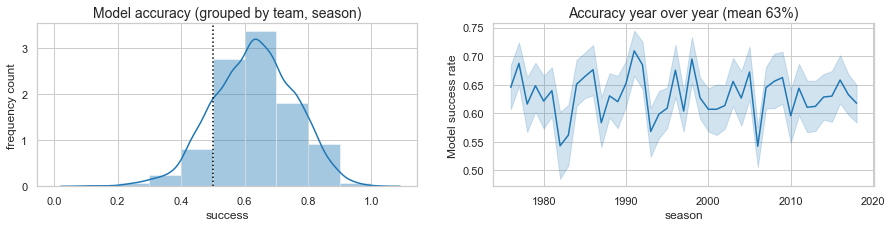

In [24]:



## Start the actual plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
f, ax = plt.subplots(1, 2)

summary = b.groupby(['team1', 'season'], as_index=False).success.mean()

# Histogram
sns.distplot(summary.success, ax=ax[0], bins=np.linspace(0, 1, 11))
ax[0].axvline(0.5, color='k', linestyle=':')
ax[0].set_ylabel("frequency count")
ax[0].set_title('Model accuracy (grouped by team, season)', fontsize=14)

# Time series
sns.lineplot(x="season", y="success", data=summary, ax=ax[1])
ax[1].set_ylabel("Model success rate")
ax[1].set_title('Accuracy year over year (mean {:0.0%})'.format(b.success.mean()), fontsize=14)

# ROC
#plot_roc(b.pwin, b.result1, resolution=100, ax=ax[2])

So our best model with the Beta posterior has about 63% accuracy, and an area under the ROC curve of about 0.68.

That will be your *baseline*. Your final project goal will be to attempt to *improve* the accuracy of predicting the winning team by *refining* the model.

Note that we *did not* use `PyMC3` to determine our hyperparameters, because we are very good in math after taking INFO 6105, and we are also very good at googling Wikipedia, which gives us the math formulas for our hyperparameters based on empirical data, once we picked a model.

However, maybe we have a*better* idea for a more refined model for which no exact math formulas are known, and we have to simulate in order to find the hyperparametes, for example with `PyMC3`...

# Mode for the prediction of score point spread

[Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#Continuous_distributions) lists hyperparameters for all exponential models.

The hyperparameters for the [Student-T distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) are:

$$
\begin{aligned}
    \nu &= \text{number of games} \\
    \mu &= \text{running mean of spread} \\
    \alpha &= \nu / 2 \\
    \beta &= (\text{running sum of the squared deviations}) / 2
\end{aligned}
$$

If we use a Student-T model $stt$ for the point spread, then the probability for point-spread $x$ is:

$$
\text{Pr}(x) = stt_{2\alpha}\left(x \;|\; \mu,\; \sigma^2 = \frac{\beta (\nu + 1)}{\alpha\nu}\right)
$$

Updates are done by these rules:

* Increment $\nu$ each game, $\nu' = \nu + 1$
* Intermediate variable $\delta = x - \mu$
* The running mean is $\mu' = \mu + \delta / \nu'$
* The running sum of squared deviations is $2\beta = 2\beta + \delta * \mu'$


The default initial value sets $\mu = 0$, and the number of observations `n_obs` to 3. The parameters for mean reversion, tuned for performance, for the beginning of every season are:

* Set $\nu$ to 3 games.
* Revert $\mu$ back to zero keeping 50% of last year's final value.
* Revert $\beta$ back to the mean $\beta$ of all teams in the prior year, scaled down to 3 games. Keep 50% of last year's final value.

In [25]:
class StudentTUpdater(Updater):
    def __init__(self):
        super().__init__('nu1', 'mu1', 'alpha1', 'beta1')
        
    def get_mean_beta(self, season):
        mean_beta = 16**2 / 2  # Default
        if season in self.lookup:
            team_sets = self.lookup[season].values()
            mean_beta = (
                sum(ts[-1].beta1 for ts in team_sets)
                / sum(ts[-1].nu1 for ts in team_sets))
        return mean_beta
        
    def revert_to_mean(self, season, team, keep=.5, n_obs=3):
        mean_beta = self.get_mean_beta(season - 1)  # Default
        nu, mu, alpha, beta = n_obs, 0, n_obs / 2, mean_beta * n_obs
        # or use existing data
        if season in self.lookup and team in self.lookup[season]:
            last_entry = self.lookup[season][team].pop()
            date, nu0, mu0, alpha0, beta0 = last_entry
            mu = keep * mu0
            beta = nu * (keep * beta0 / nu0 + (1 - keep) * mean_beta)
            # push back the reverted value to the list
            self.lookup[season][team].append(self.Params(date, nu, mu, alpha, beta))
        return nu, mu, alpha, beta
            
    def update(self, row):
        if row.season not in self.lookup:
            self.lookup[row.season] = {}
        if row.team1 not in self.lookup[row.season]:
            self.lookup[row.season][row.team1] = []
            nu, mu, alpha, beta = self.revert_to_mean(row.season - 1, row.team1)
        else:
            __, nu, mu, alpha, beta = self.lookup[row.season][row.team1][-1]
        # update-step:
        delta = row.spread - mu
        nu_mu_alpha_beta_next = self.Params(
            row.date,
            nu + 1,                       # nu' = nu + 1
            mu + delta / (nu + 1),        # mu' = mu + delta / (nu + 1)
            alpha + .5,                   # alpha' = alpha + 1/2
            beta + delta * (mu + delta / (nu + 1)) / 2
                                          # beta' = beta + delta * mu' / 2
        )
        self.lookup[row.season][row.team1].append(nu_mu_alpha_beta_next)
        return nu, mu, alpha, beta

Let's instantiate our Student-T updater, and use it to model the point-spread of the 2018 New England Patriots:

In [26]:
stt_updater = StudentTUpdater()
for i, row in by_team.iterrows():
    stt_updater.update(row)

params_nmab = pd.DataFrame(stt_updater.get_rows()).sort_values(['team1','season'])
g = params_nmab.groupby('team1')
params_nmab = params_nmab.assign(
    nu1 = g.nu1.shift(),
    mu1 = g.mu1.shift(),
    alpha1 = g.alpha1.shift(),
    beta1=g.beta1.shift())

stt_dataset = (
    by_team[[c for c in by_team.columns if c != 'result1']]
    .merge(params_nmab, on=['season', 'date', 'team1'])
    .reindex(columns=[
        'season', 'date', 'home', 'neutral', 'playoff',
        'team1', 'team2', 'spread', 'nu1', 'mu1', 'alpha1', 'beta1'])
)

print("2018 New England Patriots:")
stt_dataset[(stt_dataset.season == 2018) & (stt_dataset.team1 == 'NE')]

2018 New England Patriots:


season        date  home  neutral  playoff team1 team2  spread   nu1  \
20982    2018  2018-09-09     1        0        0    NE   HOU       7   3.0   
20983    2018  2018-09-16     0        0        0    NE   JAX     -11   4.0   
20984    2018  2018-09-23     0        0        0    NE   DET     -16   5.0   
20985    2018  2018-09-30     1        0        0    NE   MIA      31   6.0   
20986    2018  2018-10-04     1        0        0    NE   IND      14   7.0   
20987    2018  2018-10-14     1        0        0    NE    KC       3   8.0   
20988    2018  2018-10-21     0        0        0    NE   CHI       7   9.0   
20989    2018  2018-10-29     0        0        0    NE   BUF      19  10.0   
20990    2018  2018-11-04     1        0        0    NE    GB      14  11.0   
20991    2018  2018-11-11     0        0        0    NE   TEN     -24  12.0   
20992    2018  2018-11-25     0        0        0    NE   NYJ      14  13.0   
20993    2018  2018-12-02     1        0        0    NE   MIN      14  14.0   
20994    2018  2018-12-09     0        0        0    NE   MIA      -1  15.0   
20995    2018  2018-12-16     0        0        0    NE   PIT      -7  16.0   
20996    2018  2018-12-23     1        0        0    NE   BUF      12  17.0   
20997    2018  2018-12-30     1        0        0    NE   NYJ      35  18.0   
20998    2018  2019-01-13     1        0        1    NE   LAC      13  19.0   
20999    2018  2019-01-20     0        0        1    NE    KC       6  20.0   
21000    2018  2019-02-03     0        1        1    NE   LAR      10  21.0   

            mu1  alpha1       beta1  
20982  4.449530     1.5   30.400433  
20983  5.087148     2.0   36.887741  
20984  1.869718     2.5   21.848524  
20985 -1.108568     3.0   31.753424  
20986  3.478370     3.5   87.596167  
20987  4.793574     4.0  112.814272  
20988  4.594288     4.5  108.694175  
20989  4.834859     5.0  114.509814  
20990  6.122599     5.5  157.873555  
20991  6.779049     6.0  184.574199  
20992  4.411430     6.5  116.684386  
20993  5.096328     7.0  141.117635  
20994  5.689906     7.5  166.448164  
20995  5.271787     8.0  148.814284  
20996  4.549917     8.5  120.896477  
20997  4.963811     9.0  139.386877  
20998  6.544663     9.5  237.675241  
20999  6.867430    10.0  259.841028  
21000  6.826123    10.5  256.880438

Let's convert back to the original layout of one row per game. Combining the two teams' hyperparameters is a little more complicated than for the Beta distribution. The distribution for the spread $x$ will be:

$$
\text{Pr}(\text{team}_1 x) =
   t_{2\alpha}\left(x \;|\; \mu,\; \sigma^2 = \frac{\beta (\nu + 1)}{\alpha\nu}\right)
$$

in which

$$
\begin{aligned}
  \nu &= \nu_1 + \nu_2 \\
  \alpha &= \alpha_1 + \alpha_2 \\
  \mu &= \frac{\nu_1 \mu_1 - \nu_2 \mu_2}{\nu_1 + \nu_2} \\
  \beta &= \beta_1 + \beta_2 + \frac{\nu_1 \nu_2}{\nu_1 + \nu_2} \frac{(\mu_1 + \mu_2)^2}{2}
\end{aligned}
$$

In [27]:
stt = (
    stt_dataset[['season', 'date', 'team1', 'nu1', 'mu1', 'alpha1', 'beta1']]
    .rename(columns=dict(
        team1='team2', nu1='nu2', mu1='mu2', alpha1='alpha2', beta1='beta2'))
    .merge(stt_dataset, on=['season', 'date', 'team2'])
    .join(
        rolling_avg[['spread_advantage']]
        .rename(columns={'spread_advantage':'home_advantage'})
        , on='season')
)

# pspread is the predicted point spread, pwin the probability that the spread is > 0,
# and we'll say we're successful if team1 won while we predicted a positive spread
stt = (
    stt.assign(
        pspread =
            (stt.nu1 * stt.mu1 - stt.nu2 * stt.mu2) / (stt.nu1 + stt.nu2)
            # if at home and not neutral add home advantage
            + stt.home * (1 - stt.neutral) * stt.home_advantage
            # if away and not neutral subtract home advantage
            - (1 - stt.home) * (1 - stt.neutral) * stt.home_advantage
        ,
        betaprime =
            stt.beta1 + stt.beta2
            + (stt.nu1 * stt.nu2) / (stt.nu1 + stt.nu2)
            * (stt.mu1 + stt.mu2)**2 / 2
        ,
        pwin = (
            lambda row: 1 - stats.t.cdf(
                0,
                row.nu1 + row.nu2,
                loc=row.pspread,
                scale=(
                    row.betaprime
                    * (row.nu1 + row.nu2 + 1)
                    / (row.nu1 + row.nu2) / (row.alpha1 + row.alpha2)
                )))
        ,
        success = lambda row: row.pwin.round() == (row.spread > 0)
    )
    .reindex(columns=(
        list(stt_dataset.columns)
        + ['nu2', 'mu2', 'alpha2', 'beta2', 'home_advantage', 'pspread', 'pwin', 'success']
    ))
)

print(stt.success.mean())
print(stt.shape)
stt.sample(10)

0.6364365971107544
(21182, 20)


season        date  home  neutral  playoff team1 team2  spread   nu1  \
4676     1986  1986-10-05     0        0        0   BUF   NYJ      -1   7.0   
20074    2016  2016-11-13     0        0        0   CHI    TB     -26  11.0   
19150    2015  2015-10-04     0        0        0    KC   CIN     -15   6.0   
15168    2007  2007-11-22     1        0        0   DAL   NYJ      31  13.0   
4648     1986  1986-11-23     1        0        0   LAR    NO      13  14.0   
17673    2012  2012-11-18     1        0        0    NE   IND      35  12.0   
8925     1995  1995-12-24     0        0        0   DEN   OAK       3  18.0   
20993    2018  2018-12-02     0        0        0   MIN    NE     -14  14.0   
9893     1997  1997-11-30     0        0        0    TB   NYG      12  15.0   
4367     1986  1986-11-23     0        0        0    KC   ARI      -9  14.0   

            mu1  alpha1       beta1   nu2       mu2  alpha2       beta2  \
4676  -2.656356     3.5   14.710766   7.0  3.368822     3.5   71.595650   
20074 -4.879431     5.5   39.350218  11.0 -5.345502     5.5  122.275996   
19150 -0.614375     3.0   25.387034   6.0  5.001623     3.0   66.885302   
15168  8.584486     6.5  160.503079  13.0 -5.126992     6.5   74.511818   
4648   1.167767     7.0   35.390187  14.0  1.510593     7.0   72.537761   
17673  9.420059     6.0  213.492920  12.0 -2.453140     6.0    2.563224   
8925   2.029046     9.0  140.038204  18.0  0.946993     9.0   23.341039   
20993  1.897624     7.0   66.442686  14.0  5.096328     7.0  141.117635   
9893   2.910418     7.5   57.345391  15.0  0.422335     7.5   70.846983   
4367   0.396575     7.0   64.944686  14.0 -9.520079     7.0  236.941115   

       home_advantage   pspread      pwin  success  
4676         2.982833 -5.995421  0.330072     True  
20074        2.556804 -2.323768  0.478539     True  
19150        2.940075 -5.748074  0.398585     True  
15168        2.374532  9.230271  0.661724     True  
4648         2.982833  2.811419  0.611379     True  
17673        2.656679  8.593279  0.606677     True  
8925         2.683688 -2.142662  0.427273    False  
20993        2.389513 -3.988865  0.443910     True  
9893         2.728061 -1.484019  0.449959    False  
4367         2.982833  1.975494  0.517792    False

Text(0.5, 1.0, 'Accuracy year over year (mean 64%)')

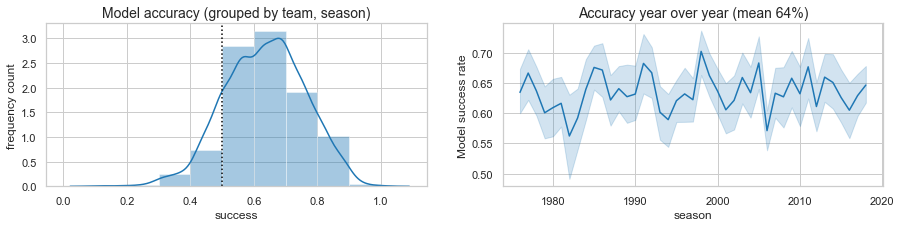

In [28]:
plt.rcParams['figure.figsize'] = (15.0, 3.0)
f, ax = plt.subplots(1, 2)

summary = stt.groupby(['team1', 'season'], as_index=False).success.mean()

# Histogram
sns.distplot(summary.success, ax=ax[0], bins=np.linspace(0, 1, 11))
ax[0].axvline(0.5, color='k', linestyle=':')
ax[0].set_ylabel("frequency count")
ax[0].set_title('Model accuracy (grouped by team, season)', fontsize=14)

# Time series
sns.lineplot(x="season", y="success", data=summary, ax=ax[1])
ax[1].set_ylabel("Model success rate")
ax[1].set_title('Accuracy year over year (mean {:0.0%})'.format(stt.success.mean()), fontsize=14)

# ROC
#plot_roc(stt.pwin, stt.spread > 0, resolution=100, ax=ax[2])

Using the probit link to connect our Student-T model of point spread to a win/loss prediction, we get performance similar to our Beta model, with an AUC of 0.67 under the ROC plot. Nothing to write home about.

## Conclusion
Nevertheless, it seems it is possible to use nothing but home advantage and historical win/loss data to achieve better than 60% predictive accuracy year over year for NFL wins with a Bayesian approach.

Now that you have a baseline model, the hyperparameters from the Bayesian method can be part of your feature engineering pipeline.

Now it's up to you what to *refine* the model with, but my first idea would be to rely on the *players* that constitute the team. After all, there are *tons* of statistics on them!

So I want to give you some additional hints for building player-based models.

# Improved Model

# Coach_NFL Notebook-Model-2

We thought the person who trains the team would be an better option to predict the winning probabilty.
So started with the Coach data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # at least 0.19.2 to read_csv from url
import seaborn as sns
import scipy.stats as stats
from collections import OrderedDict

sns.set_context("notebook")
sns.set_style("white")

df = pd.read_csv("/Project/data/games.csv")
print(df.shape)
df.head(5)

(5839, 36)


game_id  season game_type  week     gameday weekday gametime  \
0  1999_01_MIN_ATL    1999       REG     1  1999-09-12  Sunday      NaN   
1   1999_01_KC_CHI    1999       REG     1  1999-09-12  Sunday      NaN   
2  1999_01_PIT_CLE    1999       REG     1  1999-09-12  Sunday      NaN   
3   1999_01_OAK_GB    1999       REG     1  1999-09-12  Sunday      NaN   
4  1999_01_BUF_IND    1999       REG     1  1999-09-12  Sunday      NaN   

  away_team  away_score home_team  ...  div_game      roof    surface  temp  \
0       MIN        17.0       ATL  ...         0      dome  astroturf   NaN   
1        KC        17.0       CHI  ...         0  outdoors      grass  80.0   
2       PIT        43.0       CLE  ...         1  outdoors      grass  78.0   
3       OAK        24.0        GB  ...         0  outdoors      grass  67.0   
4       BUF        14.0       IND  ...         1      dome  astroturf   NaN   

   wind          away_coach    home_coach        referee  stadium_id  \
0   NaN        Dennis Green    Dan Reeves   Gerry Austin       ATL00   
1  12.0  Gunther Cunningham   Dick Jauron   Phil Luckett       CHI98   
2  12.0         Bill Cowher  Chris Palmer    Bob McElwee       CLE00   
3  10.0          Jon Gruden    Ray Rhodes  Tony Corrente       GNB00   
4   NaN       Wade Phillips      Jim Mora       Ron Blum       IND99   

                    stadium  
0              Georgia Dome  
1             Soldier Field  
2  Cleveland Browns Stadium  
3             Lambeau Field  
4                  RCA Dome  

[5 rows x 36 columns]

We have calcuated the spread by subtracting home score and away score of a team under particular coach

In [2]:
# First create the "spread" column
df['spread'] = df.home_score - df.away_score

In [5]:
df.loc[df['result'] < 0, 'result1'] = 1 
df.loc[df['result'] > 0, 'result1'] = 0
df.loc[df['result'] == 0, 'result1'] = 0.5

In [6]:
df

game_id  season game_type  week     gameday weekday gametime  \
0     1999_01_MIN_ATL    1999       REG     1  1999-09-12  Sunday      NaN   
1      1999_01_KC_CHI    1999       REG     1  1999-09-12  Sunday      NaN   
2     1999_01_PIT_CLE    1999       REG     1  1999-09-12  Sunday      NaN   
3      1999_01_OAK_GB    1999       REG     1  1999-09-12  Sunday      NaN   
4     1999_01_BUF_IND    1999       REG     1  1999-09-12  Sunday      NaN   
...               ...     ...       ...   ...         ...     ...      ...   
5834  2020_17_WAS_PHI    2020       REG    17  2021-01-03  Sunday    13:00   
5835   2020_17_ATL_TB    2020       REG    17  2021-01-03  Sunday    13:00   
5836   2020_17_LV_DEN    2020       REG    17  2021-01-03  Sunday    16:25   
5837   2020_17_ARI_LA    2020       REG    17  2021-01-03  Sunday    16:25   
5838   2020_17_SEA_SF    2020       REG    17  2021-01-03  Sunday    16:25   

     away_team  away_score home_team  ...    surface  temp  wind  \
0          MIN        17.0       ATL  ...  astroturf   NaN   NaN   
1           KC        17.0       CHI  ...      grass  80.0  12.0   
2          PIT        43.0       CLE  ...      grass  78.0  12.0   
3          OAK        24.0        GB  ...      grass  67.0  10.0   
4          BUF        14.0       IND  ...  astroturf   NaN   NaN   
...        ...         ...       ...  ...        ...   ...   ...   
5834       WAS         NaN       PHI  ...        NaN   NaN   NaN   
5835       ATL         NaN        TB  ...        NaN   NaN   NaN   
5836        LV         NaN       DEN  ...        NaN   NaN   NaN   
5837       ARI         NaN        LA  ...        NaN   NaN   NaN   
5838       SEA         NaN        SF  ...        NaN   NaN   NaN   

              away_coach     home_coach        referee  stadium_id  \
0           Dennis Green     Dan Reeves   Gerry Austin       ATL00   
1     Gunther Cunningham    Dick Jauron   Phil Luckett       CHI98   
2            Bill Cowher   Chris Palmer    Bob McElwee       CLE00   
3             Jon Gruden     Ray Rhodes  Tony Corrente       GNB00   
4          Wade Phillips       Jim Mora       Ron Blum       IND99   
...                  ...            ...            ...         ...   
5834          Ron Rivera  Doug Pederson            NaN       PHI00   
5835       Raheem Morris   Bruce Arians            NaN       TAM00   
5836          Jon Gruden     Vic Fangio            NaN       DEN00   
5837     Kliff Kingsbury     Sean McVay            NaN       LAX01   
5838        Pete Carroll  Kyle Shanahan            NaN       SFO01   

                         stadium  spread  result1  
0                   Georgia Dome    -3.0      1.0  
1                  Soldier Field     3.0      0.0  
2       Cleveland Browns Stadium   -43.0      1.0  
3                  Lambeau Field     4.0      0.0  
4                       RCA Dome    17.0      0.0  
...                          ...     ...      ...  
5834     Lincoln Financial Field     NaN      NaN  
5835       Raymond James Stadium     NaN      NaN  
5836  Empower Field at Mile High     NaN      NaN  
5837                SoFi Stadium     NaN      NaN  
5838              Levi's Stadium     NaN      NaN  

[5839 rows x 38 columns]

In [7]:
df = df.dropna(axis=0, subset=['away_score'])

In [8]:
df

game_id  season game_type  week     gameday  weekday gametime  \
0     1999_01_MIN_ATL    1999       REG     1  1999-09-12   Sunday      NaN   
1      1999_01_KC_CHI    1999       REG     1  1999-09-12   Sunday      NaN   
2     1999_01_PIT_CLE    1999       REG     1  1999-09-12   Sunday      NaN   
3      1999_01_OAK_GB    1999       REG     1  1999-09-12   Sunday      NaN   
4     1999_01_BUF_IND    1999       REG     1  1999-09-12   Sunday      NaN   
...               ...     ...       ...   ...         ...      ...      ...   
5770   2020_13_NE_LAC    2020       REG    13  2020-12-06   Sunday    16:25   
5771   2020_13_DEN_KC    2020       REG    13  2020-12-06   Sunday    20:20   
5772  2020_13_WAS_PIT    2020       REG    13  2020-12-07   Monday    17:00   
5773   2020_13_BUF_SF    2020       REG    13  2020-12-07   Monday    20:15   
5774  2020_13_DAL_BAL    2020       REG    13  2020-12-08  Tuesday    20:05   

     away_team  away_score home_team  ...    surface  temp  wind  \
0          MIN        17.0       ATL  ...  astroturf   NaN   NaN   
1           KC        17.0       CHI  ...      grass  80.0  12.0   
2          PIT        43.0       CLE  ...      grass  78.0  12.0   
3          OAK        24.0        GB  ...      grass  67.0  10.0   
4          BUF        14.0       IND  ...  astroturf   NaN   NaN   
...        ...         ...       ...  ...        ...   ...   ...   
5770        NE        45.0       LAC  ...        NaN   NaN   NaN   
5771       DEN        16.0        KC  ...        NaN   NaN   NaN   
5772       WAS        23.0       PIT  ...        NaN   NaN   NaN   
5773       BUF        34.0        SF  ...        NaN   NaN   NaN   
5774       DAL        17.0       BAL  ...        NaN   NaN   NaN   

              away_coach     home_coach        referee  stadium_id  \
0           Dennis Green     Dan Reeves   Gerry Austin       ATL00   
1     Gunther Cunningham    Dick Jauron   Phil Luckett       CHI98   
2            Bill Cowher   Chris Palmer    Bob McElwee       CLE00   
3             Jon Gruden     Ray Rhodes  Tony Corrente       GNB00   
4          Wade Phillips       Jim Mora       Ron Blum       IND99   
...                  ...            ...            ...         ...   
5770      Bill Belichick   Anthony Lynn            NaN       LAX01   
5771          Vic Fangio      Andy Reid            NaN       KAN00   
5772          Ron Rivera    Mike Tomlin            NaN       PIT00   
5773      Sean McDermott  Kyle Shanahan            NaN       PHO00   
5774       Mike McCarthy  John Harbaugh            NaN       BAL00   

                       stadium  spread  result1  
0                 Georgia Dome    -3.0      1.0  
1                Soldier Field     3.0      0.0  
2     Cleveland Browns Stadium   -43.0      1.0  
3                Lambeau Field     4.0      0.0  
4                     RCA Dome    17.0      0.0  
...                        ...     ...      ...  
5770              SoFi Stadium   -45.0      1.0  
5771         Arrowhead Stadium     6.0      0.0  
5772               Heinz Field    -6.0      1.0  
5773        State Farm Stadium   -10.0      1.0  
5774          M&T Bank Stadium    17.0      0.0  

[5775 rows x 38 columns]

In [9]:
df = df.rename(columns = {"home_team":"team1"}) # Renaming the columns
df = df.rename(columns = {"away_team":"team2"})
df = df.rename(columns = {"home_coach":"coach1"})
df = df.rename(columns = {"away_coach":"coach2"})
df = df.rename(columns = {"gameday":"date"})

In [10]:
df

game_id  season game_type  week        date  weekday gametime  \
0     1999_01_MIN_ATL    1999       REG     1  1999-09-12   Sunday      NaN   
1      1999_01_KC_CHI    1999       REG     1  1999-09-12   Sunday      NaN   
2     1999_01_PIT_CLE    1999       REG     1  1999-09-12   Sunday      NaN   
3      1999_01_OAK_GB    1999       REG     1  1999-09-12   Sunday      NaN   
4     1999_01_BUF_IND    1999       REG     1  1999-09-12   Sunday      NaN   
...               ...     ...       ...   ...         ...      ...      ...   
5770   2020_13_NE_LAC    2020       REG    13  2020-12-06   Sunday    16:25   
5771   2020_13_DEN_KC    2020       REG    13  2020-12-06   Sunday    20:20   
5772  2020_13_WAS_PIT    2020       REG    13  2020-12-07   Monday    17:00   
5773   2020_13_BUF_SF    2020       REG    13  2020-12-07   Monday    20:15   
5774  2020_13_DAL_BAL    2020       REG    13  2020-12-08  Tuesday    20:05   

     team2  away_score team1  ...    surface  temp  wind              coach2  \
0      MIN        17.0   ATL  ...  astroturf   NaN   NaN        Dennis Green   
1       KC        17.0   CHI  ...      grass  80.0  12.0  Gunther Cunningham   
2      PIT        43.0   CLE  ...      grass  78.0  12.0         Bill Cowher   
3      OAK        24.0    GB  ...      grass  67.0  10.0          Jon Gruden   
4      BUF        14.0   IND  ...  astroturf   NaN   NaN       Wade Phillips   
...    ...         ...   ...  ...        ...   ...   ...                 ...   
5770    NE        45.0   LAC  ...        NaN   NaN   NaN      Bill Belichick   
5771   DEN        16.0    KC  ...        NaN   NaN   NaN          Vic Fangio   
5772   WAS        23.0   PIT  ...        NaN   NaN   NaN          Ron Rivera   
5773   BUF        34.0    SF  ...        NaN   NaN   NaN      Sean McDermott   
5774   DAL        17.0   BAL  ...        NaN   NaN   NaN       Mike McCarthy   

             coach1        referee  stadium_id                   stadium  \
0        Dan Reeves   Gerry Austin       ATL00              Georgia Dome   
1       Dick Jauron   Phil Luckett       CHI98             Soldier Field   
2      Chris Palmer    Bob McElwee       CLE00  Cleveland Browns Stadium   
3        Ray Rhodes  Tony Corrente       GNB00             Lambeau Field   
4          Jim Mora       Ron Blum       IND99                  RCA Dome   
...             ...            ...         ...                       ...   
5770   Anthony Lynn            NaN       LAX01              SoFi Stadium   
5771      Andy Reid            NaN       KAN00         Arrowhead Stadium   
5772    Mike Tomlin            NaN       PIT00               Heinz Field   
5773  Kyle Shanahan            NaN       PHO00        State Farm Stadium   
5774  John Harbaugh            NaN       BAL00          M&T Bank Stadium   

      spread  result1  
0       -3.0      1.0  
1        3.0      0.0  
2      -43.0      1.0  
3        4.0      0.0  
4       17.0      0.0  
...      ...      ...  
5770   -45.0      1.0  
5771     6.0      0.0  
5772    -6.0      1.0  
5773   -10.0      1.0  
5774    17.0      0.0  

[5775 rows x 38 columns]

~ Overall ~

~ Past few seasons ~
          spread   result1
season                    
2012    2.441948  0.428839
2013    2.992509  0.398876
2014    2.647940  0.425094
2015    1.689139  0.453184
2016    3.037453  0.415730
2017    2.580524  0.430712
2018    2.138577  0.404494
2019    0.041199  0.477528
2020    0.036458  0.497396


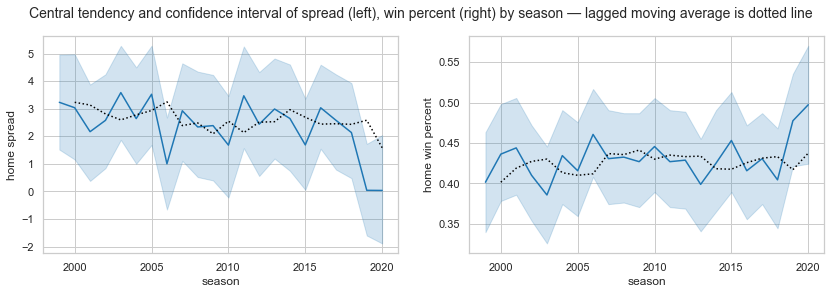

In [11]:
import warnings
warnings.filterwarnings("ignore")

# Show some of the values
print("~ Overall ~")
#print(df[df.neutral == 0][['spread', 'result1']].mean())
print("\n~ Past few seasons ~")
print(df[(df.season > 2011)].groupby('season')[['spread', 'result1']].mean())

# Create a data frame with lagged rolling means and combine with the existing data
rolling_avg = (
    df.groupby('season')[['spread', 'result1']].mean()
    .rolling(3, min_periods=1)
    .mean()
    .shift(1)
)
rolling_avg['win_pct_advantage'] =  rolling_avg.result1 - .5
rolling_avg['spread_advantage'] = rolling_avg.spread
rolling_avg = rolling_avg.drop(columns=['result1', 'spread'])


# Plot everything
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14.0, 4.0)
f, ax = plt.subplots(1, 2)
sns.lineplot(x="season", y="spread", data=df, ax=ax[0])
ax[0].plot(rolling_avg.index, rolling_avg.spread_advantage, 'k:')
ax[0].set_ylabel("home spread")

sns.lineplot(x="season", y="result1", data=df, ax=ax[1])
ax[1].plot(rolling_avg.index, rolling_avg.win_pct_advantage + .5, 'k:')
ax[1].set_ylabel("home win percent")
plt.suptitle(
    'Central tendency and confidence interval of spread (left), '
    'win percent (right) by season — lagged moving average is dotted line',
    fontsize=14);

In [12]:
home_games = df[[
    'date','game_id', 'season', 'team1', 'team2', 'result1', 'spread', 'coach1', 'coach2'
]][df.season > 1975]
home_games['home'] = 1

# Now swap the teams for "away"
away_games = home_games.rename(columns={'team1':'team2', 'team2':'team1', 'coach1':'coach2', 'coach2':'coach1'})
away_games['home'] = 1 - home_games.home
# Remember to switch the meaning of the winning and spread columns too
away_games['result1'] = 1 - home_games.result1
away_games['spread'] = - home_games.spread

by_team = (
    pd.concat([home_games, away_games], ignore_index=True)
    .sort_values(by=['season', 'team1', 'date'])
)
by_team.sample(10)

date          game_id  season team1 team2  result1  spread  \
9770  2014-09-08  2014_01_NYG_DET    2014   NYG   DET      1.0   -21.0   
2694  2009-10-04  2009_04_DET_CHI    2009   CHI   DET      0.0    24.0   
9104  2011-11-20  2011_11_CAR_DET    2011   CAR   DET      1.0   -14.0   
9663  2013-11-24   2013_12_DEN_NE    2013   DEN    NE      1.0    -3.0   
6404  2001-11-04   2001_08_NYJ_NO    2001   NYJ    NO      0.0     7.0   
727   2001-12-23    2001_15_SD_KC    2001    KC    SD      0.0     3.0   
3188  2011-09-11   2011_01_DET_TB    2011    TB   DET      1.0    -7.0   
7227  2004-11-14   2004_10_CAR_SF    2004   CAR    SF      0.0    10.0   
4855  2017-10-08  2017_05_BAL_OAK    2017   OAK   BAL      1.0   -13.0   
3511  2012-10-07  2012_05_MIA_CIN    2012   CIN   MIA      1.0    -4.0   

             coach1           coach2  home  
9770   Tom Coughlin     Jim Caldwell     0  
2694    Lovie Smith     Jim Schwartz     1  
9104     Ron Rivera     Jim Schwartz     0  
9663       John Fox   Bill Belichick     0  
6404   Herm Edwards      Jim Haslett     0  
727    Dick Vermeil       Mike Riley     1  
3188  Raheem Morris     Jim Schwartz     1  
7227       John Fox  Dennis Erickson     0  
4855   Jack Del Rio    John Harbaugh     1  
3511   Marvin Lewis      Joe Philbin     1

In [13]:
from abc import ABC, abstractmethod
from collections import namedtuple

class Updater(ABC):
    def __init__(self, *hyperparameters):
        # Form of lookup:
        # {season: {team: [{week1 data}, {week2 data}, ... {weekN data}]}}
        self.lookup = {}
        #self.Params = {'Params': ['date'] + list(hyperparameters)}
        # we use a named tuple so we can actually call it. A dict is not callable
        self.Params = namedtuple('Params', ['date'] + list(hyperparameters))
        
    def iterrows(self):
        for season, coachs in self.lookup.items():
            for coach, results in coachs.items():
                for row in results:
                    yield dict(season=season, coach1=coach, **row._asdict())
        
    def get_rows(self):
        return [r for r in self.iterrows()]
    
    # run at the beginning of every season
    @abstractmethod
    def revert_to_mean(self, season, coach, keep=.3, n_obs=8):
        pass
    
    @abstractmethod
    def update(self, row):
        pass

Beta Updater function inorder to update the beta distribution after every 4 games keeping retaining 80 percent of the data.
After Every win alpha is updated to alpha +1 and beta is updated to beta +1

In [14]:
class BetaUpdater(Updater):
    def __init__(self):
        super().__init__('alpha1', 'beta1')
        
    def revert_to_mean(self, season, coach, keep=.8, n_obs=4):
        # default
        alpha = beta = 1 + n_obs * .5
        
        # or use existing data        
        if season in self.lookup and coach in self.lookup[season]:
            last_entry = self.lookup[season][coach].pop()
            date, alpha0, beta0 = last_entry
            p = alpha0 / (alpha0 + beta0)
            alpha = 1 + n_obs * (keep * p + (1 - keep) * .5)
            beta = 1 + n_obs * (keep * (1 - p) + (1 - keep) * .5)
            # push back the reverted value to the list
            self.lookup[season][coach].append(self.Params(date, alpha, beta))
            
        return alpha, beta
            
    def update(self, row):
        if row.season not in self.lookup:
            self.lookup[row.season] = {}
        if row.coach1 not in self.lookup[row.season]:
            self.lookup[row.season][row.coach1] = []
            alpha, beta = self.revert_to_mean(row.season - 1, row.coach1)
        else:
            __, alpha, beta = self.lookup[row.season][row.coach1][-1]
            
        # THE UPDATE STEP:
        # a' = a + 1 if win else 0
        # b' = b + 1 if lose
        if row.result1 == 1:  # Won
            alpha_beta_next = self.Params(row.date, alpha + 1, beta)
        elif row.result1 == 0.5:  # Tie
            alpha_beta_next = self.Params(row.date, alpha + .5, beta + .5)
        else:  # Lost
            alpha_beta_next = self.Params(row.date, alpha, beta + 1)
        self.lookup[row.season][row.coach1].append(alpha_beta_next)
        return alpha, beta

In [15]:
beta_updater = BetaUpdater()
for i, row in by_team.iterrows():
    beta_updater.update(row)

ab = pd.DataFrame(beta_updater.get_rows()).sort_values(['coach1','season'])
g = ab.groupby('coach1')
ab = ab.assign(alpha1 = g.alpha1.shift(), beta1=g.beta1.shift())

beta_dataset = (
    by_team[[c for c in by_team.columns if c != 'spread']]
    .merge(ab, on=['season', 'date', 'coach1'])
    .reindex(columns=[
        'season', 'date', 'home', 
        'coach1', 'coach2', 'result1', 'alpha1', 'beta1'])
)

print()
print("Jay Gruden in 2016:")
beta_dataset[(beta_dataset.season == 2016) & (beta_dataset.coach1 == 'Jay Gruden')]


Jay Gruden in 2016:


season        date  home      coach1         coach2  result1    alpha1  \
9548    2016  2016-09-12     1  Jay Gruden    Mike Tomlin      1.0  3.011383   
9549    2016  2016-09-18     1  Jay Gruden  Jason Garrett      1.0  4.011383   
9550    2016  2016-09-25     0  Jay Gruden     Ben McAdoo      0.0  5.011383   
9551    2016  2016-10-02     1  Jay Gruden    Hue Jackson      0.0  5.011383   
9552    2016  2016-10-09     0  Jay Gruden  John Harbaugh      0.0  5.011383   
9553    2016  2016-10-16     1  Jay Gruden  Doug Pederson      0.0  5.011383   
9554    2016  2016-10-23     0  Jay Gruden   Jim Caldwell      1.0  5.011383   
9555    2016  2016-10-30     0  Jay Gruden   Marvin Lewis      0.5  6.011383   
9556    2016  2016-11-13     1  Jay Gruden    Mike Zimmer      0.0  6.511383   
9557    2016  2016-11-20     1  Jay Gruden  Mike McCarthy      0.0  6.511383   
9558    2016  2016-11-24     0  Jay Gruden  Jason Garrett      1.0  6.511383   
9559    2016  2016-12-04     0  Jay Gruden   Bruce Arians      1.0  7.511383   
9560    2016  2016-12-11     0  Jay Gruden  Doug Pederson      0.0  8.511383   
9561    2016  2016-12-19     1  Jay Gruden     Ron Rivera      1.0  8.511383   
9562    2016  2016-12-24     0  Jay Gruden       John Fox      0.0  9.511383   
9563    2016  2017-01-01     1  Jay Gruden     Ben McAdoo      1.0  9.511383   

          beta1  
9548   2.988617  
9549   2.988617  
9550   2.988617  
9551   3.988617  
9552   4.988617  
9553   5.988617  
9554   6.988617  
9555   6.988617  
9556   7.488617  
9557   8.488617  
9558   9.488617  
9559   9.488617  
9560   9.488617  
9561  10.488617  
9562  10.488617  
9563  11.488617

In [16]:
b = (
    beta_dataset[['season', 'date', 'coach1', 'alpha1', 'beta1']]
    .rename(columns=dict(coach1='coach2', alpha1='alpha2', beta1='beta2'))
    .merge(beta_dataset, on=['season', 'date', 'coach2'])
    .join(
        rolling_avg[['win_pct_advantage']]
        .rename(columns={'win_pct_advantage':'home_advantage'})
        , on='season')
)

b = (
    b.assign(
        pwin = 
        (b.alpha1 + b.beta2 - 1) / (b.alpha1 + b.beta1 + b.alpha2 + b.beta2 - 2)
        # if at home and not neutral add home advantage
        + b.home  * b.home_advantage
        # if away and not neutral subtract home advantage
        - (1 - b.home)  * b.home_advantage
        ,
        success = lambda row:  row.pwin.round() == row.result1
    )
    .reindex(columns=(
        list(beta_dataset.columns)
        + ['alpha2', 'beta2', 'home_advantage', 'pwin', 'success']
    ))
)

print(b.success.mean())
b.tail()

0.5892640692640693


season        date  home         coach1      coach2  result1  \
11545    2020  2020-11-08     0      Joe Judge  Ron Rivera      0.0   
11546    2020  2020-11-15     1  Matt Patricia  Ron Rivera      0.0   
11547    2020  2020-11-22     0     Zac Taylor  Ron Rivera      1.0   
11548    2020  2020-11-26     1  Mike McCarthy  Ron Rivera      1.0   
11549    2020  2020-12-07     1    Mike Tomlin  Ron Rivera      1.0   

          alpha1      beta1     alpha2     beta2  home_advantage      pwin  \
11545  10.000000   4.000000   8.450607  4.549393       -0.062422  0.604398   
11546   8.696860   5.303140   9.450607  4.549393       -0.062422  0.408588   
11547  10.372727   4.627273  10.450607  4.549393       -0.062422  0.559641   
11548  10.000000   6.000000  10.450607  5.549393       -0.062422  0.422558   
11549   2.953582  14.046418  10.450607  6.549393       -0.062422  0.203296   

       success  
11545    False  
11546     True  
11547     True  
11548    False  
11549    False

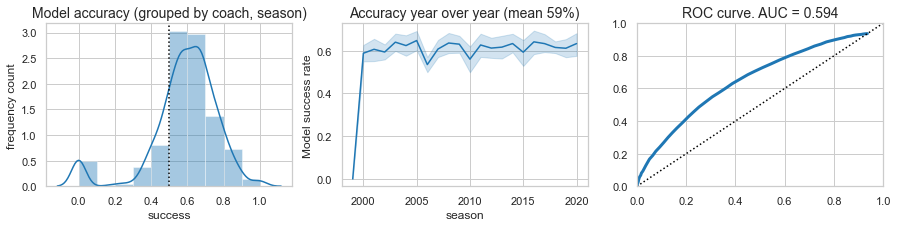

In [17]:
# use toggle
def plot_roc(predicted, actual, resolution=100, ax=None):
    """'predicted' and 'actual' are pandas Series."""
    ax = ax or plt.gca()
    cutoff = np.linspace(0, 1, resolution)
    total_pos = (actual == 1).sum()
    total_neg = (actual != 1).sum()
    true_positive_rate = np.fromiter(
        map(lambda c: (actual[predicted > c] == 1).sum() / total_pos, cutoff),
        float)
    false_positive_rate = np.fromiter(
        map(lambda c: (actual[predicted > c] != 1).sum() / total_neg, cutoff),
        float)
    ax.plot(
        false_positive_rate, true_positive_rate,
        linestyle='-', color=sns.color_palette()[0], linewidth=3)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot([0,1], [0,1], 'k:')
    # Area under the curve
    auc = sum((true_positive_rate[:-1] + true_positive_rate[1:]) / 2
              * (false_positive_rate[:-1] - false_positive_rate[1:]))
    ax.set_title('ROC curve. AUC = {:0.3f}'.format(auc), fontsize=14);


## Start the actual plot
plt.rcParams['figure.figsize'] = (15.0, 3.0)
f, ax = plt.subplots(1, 3)

summary = b.groupby(['coach1', 'season'], as_index=False).success.mean()

# Histogram
sns.distplot(summary.success, ax=ax[0], bins=np.linspace(0, 1, 11))
ax[0].axvline(0.5, color='k', linestyle=':')
ax[0].set_ylabel("frequency count")
ax[0].set_title('Model accuracy (grouped by coach, season)', fontsize=14)

# Time series
sns.lineplot(x="season", y="success", data=summary, ax=ax[1])
ax[1].set_ylabel("Model success rate")
ax[1].set_title('Accuracy year over year (mean {:0.0%})'.format(b.success.mean()), fontsize=14)

# ROC
plot_roc(b.pwin, b.result1, resolution=100, ax=ax[2])

<h1>59 Percent</h1>



# **Random Forest Algorithm**-Model-3

In [56]:
import pandas as pd
df = pd.read_csv('/Project/data/pbp_2017.csv', low_memory=False)

In [57]:
df.head()

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2017-09-07  2017090700      1    1   NaN  15:00         15    3600.0   
1  2017-09-07  2017090700      1    1   1.0  14:55         15    3595.0   
2  2017-09-07  2017090700      1    1   2.0  14:49         15    3589.0   
3  2017-09-07  2017090700      1    1   3.0  14:14         15    3554.0   
4  2017-09-07  2017090700      1    1   1.0  13:52         14    3532.0   

   PlayTimeDiff SideofField  ...    yacEPA  Home_WP_pre  Away_WP_pre  \
0           0.0          KC  ...       NaN     0.500007     0.499993   
1           5.0          NE  ... -2.950274     0.506018     0.493982   
2           6.0          NE  ...  1.665474     0.484055     0.515945   
3          35.0          NE  ...       NaN     0.510010     0.489990   
4          22.0          NE  ...       NaN     0.552982     0.447018   

   Home_WP_post  Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  Season  
0      0.506018      0.493982  0.500007  0.006011       NaN       NaN    2017  
1      0.484055      0.515945  0.506018 -0.021963  0.068249 -0.090213    2017  
2      0.510010      0.489990  0.484055  0.025955 -0.024329  0.050284    2017  
3      0.552982      0.447018  0.510010  0.042972       NaN       NaN    2017  
4      0.546975      0.453025  0.552982 -0.006007       NaN       NaN    2017  

[5 rows x 102 columns]

In [58]:
### Data transformations
df.columns = [x.strip() for x in df.columns]
df.columns = [x.replace(' ', '_') for x in df.columns]
df = df.fillna(value = 0)

In [59]:
df.head()

Date      GameID  Drive  qtr  down   time  TimeUnder  TimeSecs  \
0  2017-09-07  2017090700      1    1   0.0  15:00         15    3600.0   
1  2017-09-07  2017090700      1    1   1.0  14:55         15    3595.0   
2  2017-09-07  2017090700      1    1   2.0  14:49         15    3589.0   
3  2017-09-07  2017090700      1    1   3.0  14:14         15    3554.0   
4  2017-09-07  2017090700      1    1   1.0  13:52         14    3532.0   

   PlayTimeDiff SideofField  ...    yacEPA  Home_WP_pre  Away_WP_pre  \
0           0.0          KC  ...  0.000000     0.500007     0.499993   
1           5.0          NE  ... -2.950274     0.506018     0.493982   
2           6.0          NE  ...  1.665474     0.484055     0.515945   
3          35.0          NE  ...  0.000000     0.510010     0.489990   
4          22.0          NE  ...  0.000000     0.552982     0.447018   

   Home_WP_post  Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  Season  
0      0.506018      0.493982  0.500007  0.006011  0.000000  0.000000    2017  
1      0.484055      0.515945  0.506018 -0.021963  0.068249 -0.090213    2017  
2      0.510010      0.489990  0.484055  0.025955 -0.024329  0.050284    2017  
3      0.552982      0.447018  0.510010  0.042972  0.000000  0.000000    2017  
4      0.546975      0.453025  0.552982 -0.006007  0.000000  0.000000    2017  

[5 rows x 102 columns]

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [61]:
df.columns

Index(['Date', 'GameID', 'Drive', 'qtr', 'down', 'time', 'TimeUnder',
       'TimeSecs', 'PlayTimeDiff', 'SideofField',
       ...
       'yacEPA', 'Home_WP_pre', 'Away_WP_pre', 'Home_WP_post', 'Away_WP_post',
       'Win_Prob', 'WPA', 'airWPA', 'yacWPA', 'Season'],
      dtype='object', length=102)

In [62]:
df2=df.drop(['posteam','DefensiveTeam','time','Date','desc', 'SideofField','ExPointResult','TwoPointConv','DefTwoPoint','PuntResult','Passer_ID','PassOutcome','PassLength','PassLocation','Interceptor','Rusher_ID','Receiver_ID','ReturnResult','Returner','BlockingPlayer','FieldGoalResult','FieldGoalDistance','RecFumbTeam','ChalReplayResult','PenalizedTeam','PenaltyType','PenalizedPlayer','Timeout_Team','Passer','Rusher','PlayType','Passer','RunLocation','RunGap','Receiver','Tackler1','Tackler2','RecFumbPlayer','Timeout_Team','HomeTeam','AwayTeam'], axis = 1) 

In [63]:
df2.head()

GameID  Drive  qtr  down  TimeUnder  TimeSecs  PlayTimeDiff  yrdln  \
0  2017090700      1    1   0.0         15    3600.0           0.0   35.0   
1  2017090700      1    1   1.0         15    3595.0           5.0   27.0   
2  2017090700      1    1   2.0         15    3589.0           6.0   27.0   
3  2017090700      1    1   3.0         15    3554.0          35.0   35.0   
4  2017090700      1    1   1.0         14    3532.0          22.0   43.0   

   yrdline100  ydstogo  ...    yacEPA  Home_WP_pre  Away_WP_pre  Home_WP_post  \
0        35.0        0  ...  0.000000     0.500007     0.499993      0.506018   
1        73.0       10  ... -2.950274     0.506018     0.493982      0.484055   
2        73.0       10  ...  1.665474     0.484055     0.515945      0.510010   
3        65.0        2  ...  0.000000     0.510010     0.489990      0.552982   
4        57.0       10  ...  0.000000     0.552982     0.447018      0.546975   

   Away_WP_post  Win_Prob       WPA    airWPA    yacWPA  Season  
0      0.493982  0.500007  0.006011  0.000000  0.000000    2017  
1      0.515945  0.506018 -0.021963  0.068249 -0.090213    2017  
2      0.489990  0.484055  0.025955 -0.024329  0.050284    2017  
3      0.447018  0.510010  0.042972  0.000000  0.000000    2017  
4      0.453025  0.552982 -0.006007  0.000000  0.000000    2017  

[5 rows x 63 columns]

In [64]:
# Need to remove NA
# Regression - Try to predict Mean_Humidity (y) from non humidity columns (X)
# Get training set (X_train)
def valid(col):
    return col != 'Win_Prob'
df2_dummy = df2.dropna()

# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
X = df2_dummy[[x for x in df2_dummy.columns if valid(x)]].iloc[0:-1]

# for the dependent variable, we remove the NA, so that removes the last row, too
y = df2_dummy.Win_Prob.shift(-1).dropna()

In [65]:
X.T

0             1             2             3      \
GameID        2.017091e+09  2.017091e+09  2.017091e+09  2.017091e+09   
Drive         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
qtr           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
down          0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00   
TimeUnder     1.500000e+01  1.500000e+01  1.500000e+01  1.500000e+01   
...                    ...           ...           ...           ...   
Away_WP_post  4.939820e-01  5.159454e-01  4.899902e-01  4.470184e-01   
WPA           6.011178e-03 -2.196336e-02  2.595520e-02  4.297178e-02   
airWPA        0.000000e+00  6.824924e-02 -2.432898e-02  0.000000e+00   
yacWPA        0.000000e+00 -9.021260e-02  5.028419e-02  0.000000e+00   
Season        2.017000e+03  2.017000e+03  2.017000e+03  2.017000e+03   

                     4             5             6             7      \
GameID        2.017091e+09  2.017091e+09  2.017091e+09  2.017091e+09   
Drive         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
qtr           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
down          1.000000e+00  2.000000e+00  1.000000e+00  2.000000e+00   
TimeUnder     1.400000e+01  1.400000e+01  1.400000e+01  1.300000e+01   
...                    ...           ...           ...           ...   
Away_WP_post  4.530250e-01  3.987815e-01  3.979758e-01  3.712090e-01   
WPA          -6.006622e-03  5.424345e-02  8.057753e-04  2.676681e-02   
airWPA        0.000000e+00  5.158099e-02  0.000000e+00  1.623343e-02   
yacWPA        0.000000e+00  2.662458e-03  0.000000e+00  1.053339e-02   
Season        2.017000e+03  2.017000e+03  2.017000e+03  2.017000e+03   

                     8             9      ...         45230         45231  \
GameID        2.017091e+09  2.017091e+09  ...  2.017123e+09  2.017123e+09   
Drive         1.000000e+00  1.000000e+00  ...  2.800000e+01  2.800000e+01   
qtr           1.000000e+00  1.000000e+00  ...  4.000000e+00  4.000000e+00   
down          1.000000e+00  1.000000e+00  ...  0.000000e+00  4.000000e+00   
TimeUnder     1.300000e+01  1.300000e+01  ...  1.000000e+00  1.000000e+00   
...                    ...           ...  ...           ...           ...   
Away_WP_post  3.125392e-01  3.123828e-01  ...  0.000000e+00  8.538008e-01   
WPA           5.866978e-02  1.563563e-04  ...  0.000000e+00  7.632075e-01   
airWPA        0.000000e+00  0.000000e+00  ...  0.000000e+00  2.002247e-01   
yacWPA        0.000000e+00  0.000000e+00  ...  0.000000e+00  5.629829e-01   
Season        2.017000e+03  2.017000e+03  ...  2.017000e+03  2.017000e+03   

                     45232         45233         45234         45235  \
GameID        2.017123e+09  2.017123e+09  2.017123e+09  2.017123e+09   
Drive         2.800000e+01  2.900000e+01  2.900000e+01  2.900000e+01   
qtr           4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
down          0.000000e+00  0.000000e+00  1.000000e+00  2.000000e+00   
TimeUnder     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
...                    ...           ...           ...           ...   
Away_WP_post  7.720193e-01  7.977884e-01  8.306343e-01  9.195915e-01   
WPA          -8.178146e-02 -2.576911e-02 -3.284590e-02 -8.895716e-02   
airWPA        0.000000e+00  0.000000e+00 -5.775191e-02  0.000000e+00   
yacWPA        0.000000e+00  0.000000e+00  2.490601e-02  0.000000e+00   
Season        2.017000e+03  2.017000e+03  2.017000e+03  2.017000e+03   

                     45236         45237         45238         45239  
GameID        2.017123e+09  2.017123e+09  2.017123e+09  2.017123e+09  
Drive         2.900000e+01  2.900000e+01  2.900000e+01  3.000000e+01  
qtr           4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  
down          0.000000e+00  3.000000e+00  4.000000e+00  1.000000e+00  
TimeUnder     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
...                    ...           ...           ...           ...  
Away

In [66]:
y

0        0.506018
1        0.484055
2        0.510010
3        0.552982
4        0.546975
           ...   
45235    0.000000
45236    0.080409
45237    0.050478
45238    0.969119
45239    0.999159
Name: Win_Prob, Length: 45240, dtype: float64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [69]:
rf_model.score(X_test, y_test)

0.7942311480240379

<h1>79 percent</h1>

In [70]:
y_pred = rf_model.predict(X_test)

In [71]:
type(y_pred)

numpy.ndarray

In [72]:
y_pred[0:10]

array([0.89471627, 0.19707787, 0.7555872 , 0.53792229, 0.00806185,
       0.05949958, 0.97210716, 0.71945136, 0.32252035, 0.60478663])

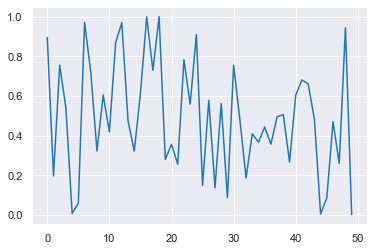

In [73]:
import matplotlib.pyplot as plt
plt.plot(y_pred[0:50])

In [74]:
type(y_test)

pandas.core.series.Series

In [75]:
y_test2 = y_test.to_numpy()
type(y_test2)

numpy.ndarray

In [76]:
y_test2[0:10]

array([9.13067297e-01, 1.27525658e-01, 9.95739342e-01, 5.39170381e-01,
       8.66240555e-03, 2.22044605e-16, 9.92603711e-01, 9.90199757e-01,
       3.15724878e-01, 6.11957533e-01])

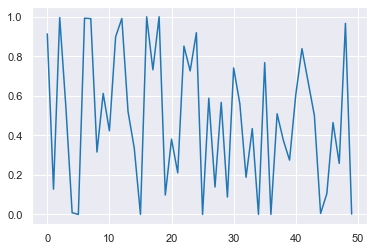

In [77]:
import matplotlib.pyplot as plt
plt.plot(y_test2[0:50])

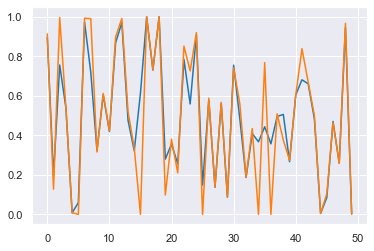

In [78]:
import matplotlib.pyplot as plt
plt.plot(y_pred[:50])
plt.plot(y_test2[:50])

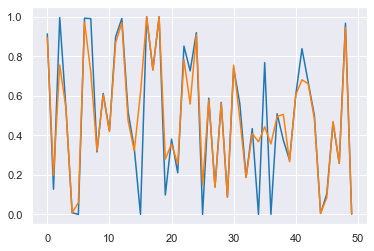

In [79]:
import matplotlib.pyplot as plt
plt.plot(y_test2[:50])
plt.plot(y_pred[:50])

In [80]:
type(y_test)

pandas.core.series.Series

In [81]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

0  Win_Prob
0      0.894716  0.913067
1      0.197078  0.127526
2      0.755587  0.995739
3      0.537922  0.539170
4      0.008062  0.008662
...         ...       ...
11305  0.490028  0.490396
11306  0.252259  0.289593
11307  0.086926  0.076908
11308  0.468636  0.493613
11309  0.489256  0.490874

[11310 rows x 2 columns]

In [82]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('ScoreDiff', 0.28788893930443293),
 ('down', 0.09662699070936948),
 ('AbsScoreDiff', 0.07679724545655897),
 ('Touchdown_Prob', 0.06714307280765963),
 ('TimeSecs', 0.053020698305205394),
 ('EPA', 0.048273188738072605),
 ('No_Score_Prob', 0.035007068709674447),
 ('TimeUnder', 0.026730703303884072),
 ('FirstDown', 0.025612841498930266),
 ('WPA', 0.022471103251809104),
 ('Away_WP_post', 0.018476112833972703),
 ('Home_WP_post', 0.018085377673209464),
 ('ydsnet', 0.01751812747331245),
 ('PlayTimeDiff', 0.014986104257893007),
 ('sp', 0.013158841740925445),
 ('Safety_Prob', 0.012609897204883383),
 ('Drive', 0.011759630100810098),
 ('GameID', 0.011289167808878831),
 ('ExpPts', 0.009633959615632385),
 ('yrdline100', 0.00934047155018185),
 ('yrdln', 0.007946421441755145),
 ('Yards_Gained', 0.007695891949174898),
 ('Opp_Safety_Prob', 0.00722830825401124),
 ('Field_Goal_Prob', 0.0069095651450075575),
 ('Away_WP_pre', 0.006720176759363933),
 ('Opp_Touchdown_Prob', 0.00670600190151379),
 ('Home_WP_

# Predict the winning result for sunday match

https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/

$$Pr(A) = 1 / (10^(-ELODIFF/400) + 1)$$

In [84]:
def expected_result(elo_a, elo_b):
    elo_width = 400
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

In [85]:
expected_result(1657, 1628) # Bills vs steelers

0.5416377027147634

 **Bills won the match last sunday and our prediction shows that bills will win the match by probability of 0.54**

In [7]:
expected_result(1515, 1602) #Vikings vs Buccaneers

0.3773498042127379

**Buccaneers won the macth and our prediction shows that Buccaneers will win the match by probability 0.62**

In [8]:
expected_result(1516, 1409) # Cardinals vs Giants

0.6492949471109635

**Cardinals won the match and our prediction shows that Cardinals will win the match by probability 0.64**

In [9]:
expected_result(1761, 1510) # Chiefs vs dolphins

0.809207997485838

**Chiefs won the match and our prediction shows that Chiefs will win the match by probability 0.80**

In [10]:
expected_result(1590, 1300) # Titans vs Jaguars

0.8414923669232418

**Titans won the match and our prediction shows that Titans will win the match by probability 0.84**

In [86]:
expected_result(1374, 1241) # Cowboys vs Bengals

0.6825703854747719

**Cowboys won the match and our prediction shows that Cowboys will win the match by probability 0.68**

# Thank you! End of our Project

# Below Code is from Professor given code

# 2. Ridge regression

Suppose you have a cloud of $x, y$ points, and you want to model the dependent variable $y$ from the independent variable $x$. For example, suppose $x$ is the *quarterback*, and $y$ is the *team*. One of the possible methods is to employ [ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization). 

This method is particularly useful to mitigate the problem of [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) in linear regression, which commonly occurs in models with large numbers of parameters, which you are bound to get into when you start considering *all* the players in a team (that is because if many of the Patriot players play well, then their performance statistics will be colinear, and thus many methods *will fail*).

>**Colinearity** is when two supposedly independent variables are actually scalar multiples of one another, or close to it. 

Mathematically speaking, in oedinary linear squares, you solve for weight estimators using:

$$\hat{\beta} = (X^T X)^{-1} X^T y$$

In ridge regression, you solve for:

$$\hat{\beta} = (X^T X + \lambda I)^{-1} X^T y$$

Where $I$ is the [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) and $\lambda$ is a new input variable that we are introducing into the model. $\lambda$ is controlled by a hyperparameter, $\alpha$, that controls how strongly we penalize overfitting.

To demonstrate this, let's invent a problem to solve. Suppose that a new video game is to be released in Japan. We have, via e.g. [Steam](http://store.steampowered.com/), the entire ranked history of video games released by this maker in North America. We'd like to build a model that predicts the sales volume for this video game in Japan given its current performance here.

In [32]:
import pandas as pd
import numpy as np
sales = pd.read_csv('data/Video_Games_Sales.csv')
sales.head()

Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating  
0          51.0          8       322.0  Nintendo      E  
1           NaN        NaN         NaN       NaN    NaN  
2          73.0        8.3       709.0  Nintendo      E  
3          73.0          8       192.0  Nintendo      E  
4           NaN        NaN         NaN       NaN    NaN

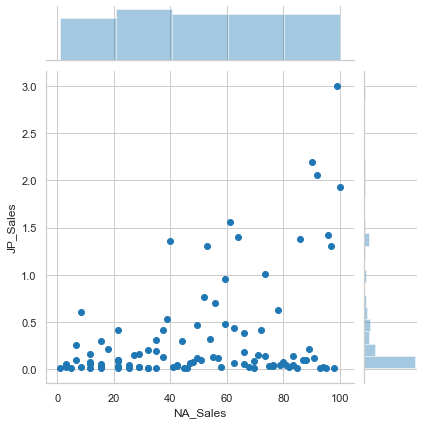

In [33]:
import seaborn as sns
s = sales[(sales.NA_Sales.notnull() & sales.JP_Sales.notnull())]
s = sales[((sales.NA_Sales > 0) & (sales.JP_Sales > 0))]
s = s.sample(100, random_state=0)
s = s.loc[s.NA_Sales.rank().sort_values().index]
sns.jointplot(s.NA_Sales.rank(), s.JP_Sales)

Let's apply linear polynomial regression to our problem:

In [34]:
NA_sales_ranks = s.NA_Sales.rank().values[:, np.newaxis]
JP_sales = s.JP_Sales.values[:, np.newaxis]

In [35]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def predict(degree):
    poly = PolynomialFeatures(degree=degree)
    NA_sales_ranks_poly = poly.fit_transform(NA_sales_ranks)
    clf = LinearRegression()
    clf.fit(NA_sales_ranks_poly, JP_sales)
    JP_sale_predictions = clf.predict(NA_sales_ranks_poly)
    result = np.dstack((JP_sales.flatten(), JP_sale_predictions.flatten())).reshape((100, 2))
    return result

Text(0.5, 1.0, 'Regression with Degree 1')

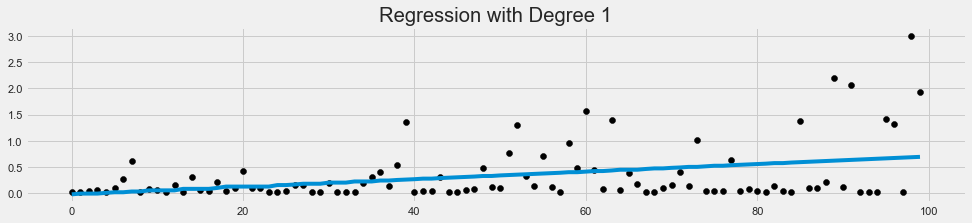

In [39]:
result = predict(1)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("Regression with Degree 1")

Text(0.5, 1.0, 'Regression with Degree 3')

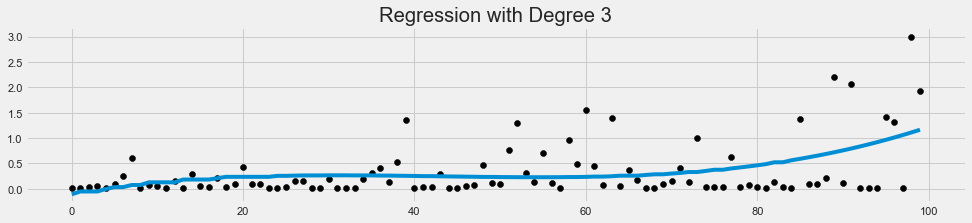

In [37]:
result = predict(3)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("Regression with Degree 3")

Text(0.5, 1.0, 'Regression with Degree 10')

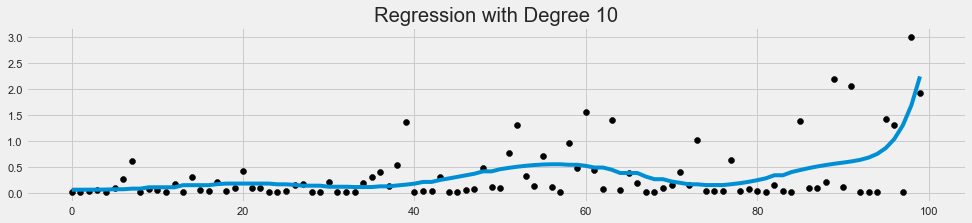

In [38]:
result = predict(10)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("Regression with Degree 10")

It appears that olynomial regression with a degree of three may be the best way to go. 

Linear regression is no good because it doesn't capture the underlying pattern of the data, which is exponential.

Regression with degree 10 creates a very complex function that's strongly overfitted.

Let's take a closer look at the coefficients (the weights $w$) assigned to the variables as a part of these models.

In [40]:
def get_model(degree):
    poly = PolynomialFeatures(degree=degree)
    NA_sales_ranks_poly = poly.fit_transform(NA_sales_ranks)
    clf = LinearRegression()
    clf.fit(NA_sales_ranks_poly, JP_sales)
    return clf

m1_coef = get_model(1).coef_
m3_coef = get_model(3).coef_
m10_coef = get_model(10).coef_

In [41]:
m1_coef

array([[0.       , 0.0072369]])

In [42]:
m3_coef

array([[ 0.00000000e+00,  3.13757975e-02, -7.73276037e-04,
         5.89804448e-06]])

In [43]:
m10_coef

array([[ 0.00000000e+00,  6.05848596e-07,  8.74501376e-08,
         1.24860888e-06,  1.01489652e-05, -1.04866670e-06,
         4.33746846e-08, -9.20155908e-10,  1.06014494e-11,
        -6.31893466e-14,  1.52884682e-16]])

What we see here that the more complex the model, the greater the magnitude of the weights assigned to it. 

We start with a relatively sane number, 0.007. The smallest coefficient in our best model (in `m3_coef`) is much, much smaller: just ~0.000006. And the least sigificant coefficient in the ten-model is incredibly tiny, just ~0.0000000000000002!

This kind of progression in degrees is typical of what happens when you overfit a polynomial model. The more degrees in the model, the larger the coefficients, because the greater the **skews** between variables necessary to optimally solve the matrix equation.

Now, if our starting point was the degree-10 function, we would *fix* our model by relaxing the number of degrees afforded to it. Back down to 3, ideally.

Ridge regression is an alternative way of achieving this coefficient shrinkage. It imposes something called an **L2 penalty** by changing our metric so that we add a penalty on the order of the square of the magnitudes of the coefficient. You can think of it as *smoothing out* the regression curve.

In the next three plots, we'll use ridge regression to squeeze the numbers back. Note that we're using very large $\alpha$ numbers here because the data is not normalized.

In [44]:
from sklearn.linear_model import Ridge

def get_ridge_model(degree, alpha):
    poly = PolynomialFeatures(degree=degree)
    NA_sales_ranks_poly = poly.fit_transform(NA_sales_ranks)
    clf = Ridge(alpha=alpha)
    clf.fit(NA_sales_ranks_poly, JP_sales)
    return clf

def ridge_predict(degree, alpha):
    poly = PolynomialFeatures(degree=degree)
    NA_sales_ranks_poly = poly.fit_transform(NA_sales_ranks)
    clf = get_ridge_model(degree, alpha)
    JP_sale_predictions = clf.predict(NA_sales_ranks_poly)
    result = np.dstack((JP_sales.flatten(), JP_sale_predictions.flatten())).reshape((100, 2))
    return result

Text(0.5, 1.0, 'degree=10, alpha=$10^1$')

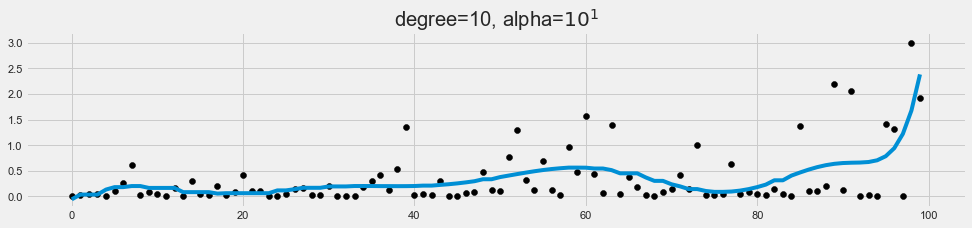

In [45]:
result = ridge_predict(10, 10)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("degree=10, alpha=$10^1$")

Text(0.5, 1.0, 'degree=10, alpha=$10^{25}$')

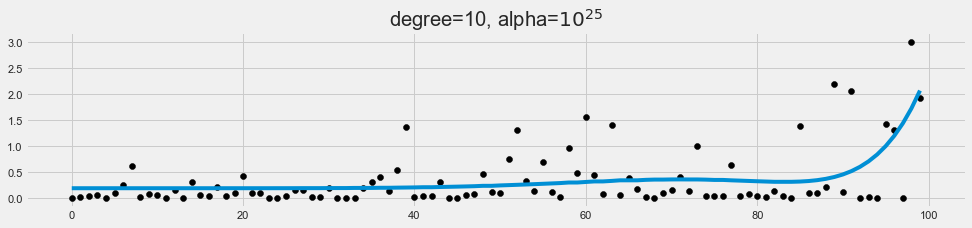

In [46]:
result = ridge_predict(10, 10**25)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("degree=10, alpha=$10^{25}$")

Text(0.5, 1.0, 'degree=10, alpha=$10^{40}$')

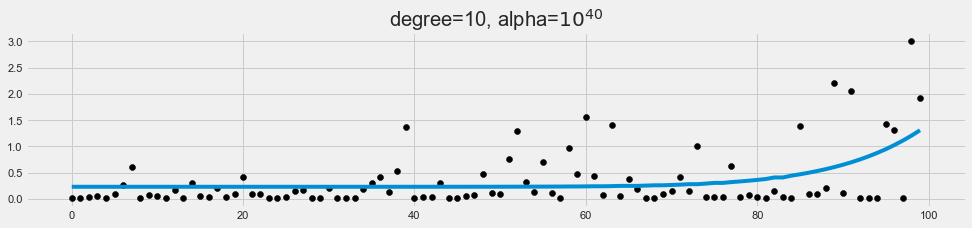

In [47]:
result = ridge_predict(10, 10**40)
plt.plot(range(len(result[:, 1])), result[:, 1])
plt.scatter(range(len(result[:, 0])), result[:, 0], color='black')
plt.gca().set_title("degree=10, alpha=$10^{40}$")

Overall, `Ridge(degree=10, alpha=10**40)` is pretty comparable to `LinearRegression(degree=3)`.

Ridge regression will never take any of the model numbers to 0 (e.g. it will never cancel variables):

In [48]:
get_ridge_model(10, 10**40).coef_

array([[0.00000000e+00, 1.72581228e-38, 1.42366282e-36, 1.13565560e-34,
        9.84967256e-33, 9.30789443e-31, 9.30901635e-29, 9.57950283e-27,
        9.96214015e-25, 1.03722742e-22, 1.07673163e-20]])

Ridge regression is theoretically most valuable when it is used to counteract the effect of colinearity. 

In practice, completely colinear variables are rare. When they do occur, they'll explode your model when you try to use it, so you'll know about them quickly. However, it's totally possible for two variables to be highly, but not totally, colinear. In this case they *share* the information that they provide to the model, to some strong degree. 

Regression does a poor job optimizing such models because it will exaggerate correlated variables: the model will want to optimize for such variables *more*, and for standalone variables providing actually unique information *less*. This is undesirable, and not something you can fix by just reducing the complexity of the model.

Going even further, in practice you will most need to use ridge regression to account for this problem in the case of large datasets with a large number of variables.

Ridge regression is mathematically straightforward and computationally effective.

# 3. Lasso regression

[Lasso](https://en.wikipedia.org/wiki/Lasso_regression) (Least Absolute Shrinkage and Selection Operator) regression, like ridge regression, functions by changing the model fitness metric. The difference is that lasso regression applies what is known as an L1 norm: it penalizes variable coefficients on the order of their absolute value, instead of on the order of the square of their value (an L2 norm, like ridge regression). But it also performs variable selection in order to enhance the prediction accuracy and interpretability of the underlying statistical model. 

In [81]:
import pandas as pd
import numpy as np

#df = pd.DataFrame(np.random.randint(-10,10,size=(100, 10)), columns=list('ABCDEFGHIJ'))
df = pd.DataFrame(np.random.uniform(-2, 2, size=(100, 10)), columns=list('ABCDEFGHIJ'))

df['winner'] = np.random.randint(0,2,size=(100, 1))
df.head(10)

A         B         C         D         E         F         G  \
0 -1.198133 -1.829063 -1.734084 -0.491719 -0.808348  1.475275  0.454256   
1 -1.969538  0.563309  0.448908  0.973888  1.425441  1.727376 -1.067781   
2  0.583678  0.663934  0.821460  0.957087 -0.050117  1.809221 -1.911494   
3 -0.468525  1.759805  1.624376 -1.107642  1.118762 -0.478298 -1.829365   
4 -1.647803  0.669043  1.558800  0.471452 -0.650498  1.010158  1.542905   
5 -0.680416  0.124466 -1.413911  1.234804 -0.037584  1.200986  0.675548   
6 -1.700940 -1.697120  0.130338 -1.214506 -1.862905 -1.750813  0.814197   
7 -0.708046  0.667342  0.362439  0.771711  0.307725  0.891212  1.122685   
8  1.214907  0.172277  0.375074 -1.919906  0.364669 -1.567826 -0.412043   
9  1.529574  1.528077  0.213080  1.181253 -1.203953 -0.900179  1.928161   

          H         I         J  winner  
0  1.010086 -1.307293  1.183112       1  
1  1.586871  0.466738 -0.717975       1  
2 -1.723593 -0.979539  1.896550       1  
3  0.658074  0.548128 -0.395967       0  
4  1.331826  1.474763 -0.705214       0  
5 -1.289133  0.723157 -1.334185       0  
6  0.560353  0.630153 -0.439054       0  
7  0.781185 -0.454839 -1.152192       0  
8  1.710150  0.698506  0.014458       1  
9  1.532722 -1.384057 -0.959573       0

In [82]:
bookie_spreads = df.iloc[:, :10].values
bookie_spreads[:3]

array([[-1.1981325 , -1.82906341, -1.73408413, -0.49171867, -0.80834815,
         1.47527461,  0.45425616,  1.01008601, -1.30729265,  1.18311194],
       [-1.96953839,  0.5633086 ,  0.44890761,  0.97388772,  1.42544124,
         1.72737552, -1.06778123,  1.58687082,  0.4667376 , -0.7179749 ],
       [ 0.58367788,  0.66393399,  0.82145997,  0.95708707, -0.05011673,
         1.80922086, -1.91149428, -1.72359329, -0.97953864,  1.89655039]])

In [83]:
outcomes = df.iloc[:, 10:].values
outcomes[:3]

array([[1],
       [1],
       [1]])

In [84]:
from sklearn.linear_model import Lasso

def get_lasso_model(alpha):
    clf = Lasso(alpha=alpha, normalize=True)
    clf.fit(bookie_spreads, outcomes)
    return clf

In [85]:
clf = get_lasso_model(0.00001)

Unlike ridge regression. lasso regression does not shrink the coefficients down to near-nothingness when it determines a variable is not adding worthwhile information to the model. Instead, it performs variable selection: it takes variables that aren't significant, and sets them to zero!

In [86]:
clf.coef_

array([-0.        , -0.02522763,  0.01945552, -0.02877079,  0.00372989,
        0.03657856, -0.0247327 , -0.08837091, -0.07855728,  0.0359678 ])

Looking at the coefficients, we see that, with an $\alpha$ of 0.00001, the first exchanges has been "cut", and all others participate in the model. The ones cut are the ones that provide the least unique information to the model: either the ones that most strongly follows the rest of the exchanges, or the one that is the wrongest.

Neither regular linear models nor ridge regression will perform this variable selection directly. This is a very useful property of ridge regression: it can be used to determine what variables provide the least information, and hence, dropped from further models that you build. Another model that does the same is *random forests*.

Let's take a quick look at model accuracy:

In [87]:
predicted_outcomes = (clf.predict(bookie_spreads) > 0.5).astype(int)

# Sort outcomes by average exchange score.
sorted_outcomes = pd.DataFrame(
    {'outcomes': outcomes.flatten(), 
     'predicted_outcomes': predicted_outcomes.flatten()}
).loc[
    np.argsort(np.average(bookie_spreads, axis=1))
].reset_index(drop=True)

In [88]:
sorted_outcomes

outcomes  predicted_outcomes
0          1                   1
1          1                   1
2          1                   1
3          0                   0
4          0                   0
..       ...                 ...
95         1                   1
96         1                   1
97         0                   0
98         0                   0
99         0                   1

[100 rows x 2 columns]

Text(0.5, 1.0, 'Predictions versus Reality')

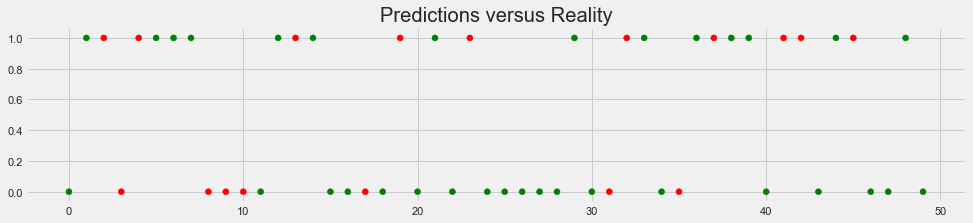

In [89]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

sample = sorted_outcomes.sample(50, random_state=5).sort_index().reset_index(drop=True)
plt.scatter(sample.index.values, 
            sample.outcomes,
            color=sample.apply(
lambda srs: 'green' if srs.outcomes == srs.predicted_outcomes else 'red', axis='columns')
           )
plt.gca().set_title('Predictions versus Reality')

In the above plot, `1.0` means player 1 won, while `0.0` means player 1 lost. 

Green means that our model predicted the match outcome correctly, while red means it predicted it incorrectly.

In [90]:
print("Our model is correct ~{0:.1f}% of the time.".format(
    (sorted_outcomes.outcomes == sorted_outcomes.predicted_outcomes).sum() / 
    len(sorted_outcomes) * 100
))

Our model is correct ~65.0% of the time.


Because it reduces the number of coefficients, lasso regression, unlike ridge regression, changes the order of the curve. Eventually, with a high enough alpha, we get back down to a linear model with one variable!

<br />
<left>
<img src="ipynb.images/lasso-output.png" width=600 />
</left>

Overall, lasso regression is an alternative to ridge regression which has roughly the same use advantage (corrects for the effect of colinearity in the model), with one important additional advantage: It can be used to remove highly colinear variables from the model.

Which exchange is the most informative one?

In [93]:
get_lasso_model(0.005).coef_

array([ 0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.03729314, -0.0379975 ,  0.        ])

8th and 9th.

# 4. Linear effects modeling with PyMC3

How do you combine multiple independent variables into one model when you *don't* have a mathematical model?

Suppose you observe and collect data over 10 games:

In [95]:
from io import StringIO

data_string = """
QR	Sacks	Points
0	1.17	3	30
1	2.97	4	20
2	3.26	1	10
3	2.69	1	4
4	3.83	2	4
5	2.00	1	25
6	4.41	2	9
7	2.21	9	19
8	3.15	7	5
9	2.41	7	40
"""

game = pd.read_table(StringIO(data_string), sep='\t', index_col=0)
game

QR  Sacks  Points
0  1.17      3      30
1  2.97      4      20
2  3.26      1      10
3  2.69      1       4
4  3.83      2       4
5  2.00      1      25
6  4.41      2       9
7  2.21      9      19
8  3.15      7       5
9  2.41      7      40

We could assume: Less than 20 points scored == loss of game, more than 20 point scored == win.

## Linear sum of squares

Let's look at the general linear effect of QR and sacks on the game score. Let's build a linear predictive model (a line).

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between modelled $\hat{y}$ and observed $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: 

1. to prevent positive and negative values from cancelling each other out
2. to strongly penalize large deviations. 

Whether or not the latter is a desired depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model. Let's write the cost function:

In [98]:
sum_of_squares = lambda θ, x, y: np.sum((y - θ[0] - θ[1]*x) ** 2)

However, we have the stated objective of minimizing the sum of squares, so we can pass this function to one of several optimizers in SciPy:

In [96]:
from scipy.optimize import fmin

x, z, y= game.T.values
x, z, y

(array([1.17, 2.97, 3.26, 2.69, 3.83, 2.  , 4.41, 2.21, 3.15, 2.41]),
 array([3., 4., 1., 1., 2., 1., 2., 9., 7., 7.]),
 array([30., 20., 10.,  4.,  4., 25.,  9., 19.,  5., 40.]))

Offense (Quaterback Rating):

In [99]:
a0, a1 = fmin(sum_of_squares, [0,1], args=(x,y))
a0, a1

Optimization terminated successfully.
         Current function value: 751.940490
         Iterations: 90
         Function evaluations: 169


(41.542376747358816, -8.876288581138382)

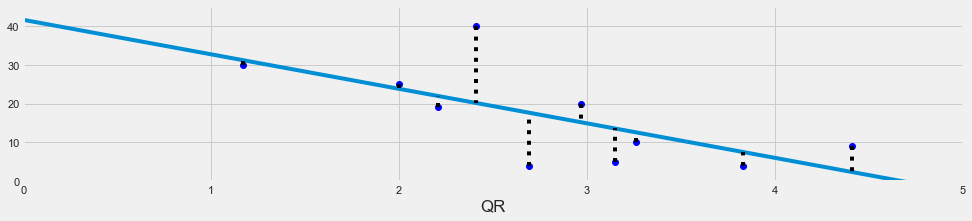

In [101]:
# QR in blue
ax = game.plot(x='QR', y='Points', style='bo', legend=False, xlim=(0,5), ylim=(0, 45))
ax.plot([0,10], [a0, a0+a1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, a0+a1*xi], 'k:')

And now for sacks (defense):

In [102]:
b0, b1 = fmin(sum_of_squares, [0,1], args=(z,y))
b0, b1

Optimization terminated successfully.
         Current function value: 1222.353393
         Iterations: 89
         Function evaluations: 170


(11.540297673329285, 1.3674812965595025)

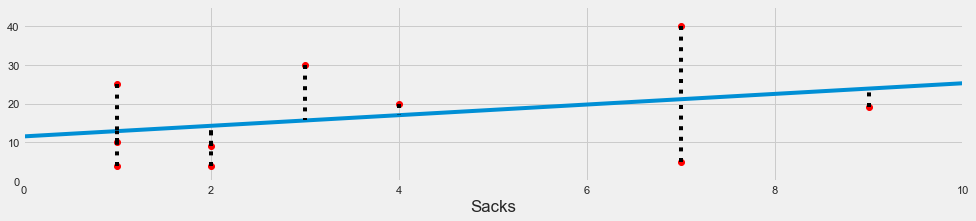

In [104]:
#defense (sacks) in red
ax = game.plot(x='Sacks', y='Points', style='ro', legend=False, xlim=(0,10), ylim=(0, 45))
ax.plot([0,10], [b0, b0+b1*10])
for zi, yi in zip(z,y):
    ax.plot([zi]*2, [yi, b0+b1*zi], 'k:')

##  Bayesian Linear Regression with PyMC3

Let's trun to a Bayesian approach and build a regression model in PyMC3 for the games we just recorded.

### Likelihood

We'll pick a **normal** distribution of Points as our model, with a **mean** and **standard deviation** as parameters:

$$y_i \sim \text{Normal}(\mu_i, \sigma)$$

Here, $\mu_i$ is the expected value of the *i*th observation, which is generated by the regression model at the corresponding value of $x$. We calculate this expected value as a function of the regression parameters and the data.

We know that a Points outcome is most often modelled as a **Poisson distribution**, but here we'll use a Normal distribution instead. It may very well not work, the probabilistic computation may fail, your laptop may go up in smoke, but it;s the simplest possible thing we can do..

We score *observed* team strength with a single scalar value: ***Points***. However, the important parameters that will help the coach devise a winning strategy are *latent* (hidden). 

Let's assume one latent parameter $\theta$ as the following linear combination of:
- a constant (the bias)
- the QR of quarterbacks
- the number of sacks of the opposing quarterback by the defense

So we write:

$$log(\theta) = \text{intercept} + \text{slope1} * \text{QR} + \text{slope2} * \text{Sacks}$$

We'll incorporate that latent parameter as the mean of the normal distribution model for ***Points***.

Let me stress: It should be a Poisson distribution instead (more appropriate for counts). But i'm using a Normal distribution, to simplify.

### Priors
The first step in specifying our model is to specify priors for our model.

Recall we use a linear model for μ, with an `intercept` (bias) factor and two linear factors `slope1` and `slope2` to represent QR and Sacks:

$$μ = \text{intercept} + \text{slope1}*x + \text{slope2}*z$$
    
We are going to model these factors as normal distributions with a *wide* support: 

$$\sim \text{Normal}(0, 100)$$

and finally the standard deviation of our modelled ***Points*** will be a **half Cauchy**:

$$\sigma \sim \text{HalfCauchy}(1)$$

The half-Cauchy distribution (half of a [Cauchy](https://en.wikipedia.org/wiki/Cauchy_distribution)) has support over positive continuous values, and relatively large tail probabilities, allowing for the possibility of extreme values. It is a very often used modeling pdf.

Since we want to track `slope1` and `slope2`, we need to add them as deterministic variables of our model: `pm.Deterministic`.

Ok, let's get cooking. We use `Deterministic` to track computed quantities inside the model. It is of no real use in the cell below, becayse if we don't specify `era` and `rbi`, slope1 and slope2 wouild be tracked anyway.

In [105]:
from pymc3 import Normal, HalfCauchy, Deterministic, Model

with Model() as game_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope1 = Normal('slope1', 0, sd=100)
    slope2 = Normal('slope2', 0, sd=100)
    era = Deterministic('qr', slope1)
    rbi = Deterministic('sacks', slope2)
    σ = HalfCauchy('σ', 1)

But here we want to track `μ`, so we set it equal to **deterministic** variable mu_d. What's the shape of mu_d?

In [ ]:
with game_model:
    
    μ = intercept + slope1*x + slope2*z
    mu_d = Deterministic('mu_d', μ)
    score = Normal('score', mu=μ, sd=σ, observed=y)

All right! Now your regression model is fully specified and you are ready to track your posteriors.

You can now use the fitting method of your choice to estimate a posterior distribution. Let's use a **Markov chain Monte Carlo** algorithm, called **NUTS** (the No U-Turn Sampler).

In [ ]:
from pymc3 import sample

with game_model:

    game_sample = sample(2000, random_seed=RANDOM_SEED)

Ok.. pymc3 tells us the results are not very good..

Let's plot posteriors anyway:

In [ ]:
from pymc3 import plot_posterior

plot_posterior(game_sample[500:], varnames=['intercept', 'qr', 'sacks', 'σ', 'mu_d']);

We have 10 `mu_d`s above, one per game.

## Checking model fit

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit the model. In other words, the fitted model can be used to **simulate
data**, and the distribution of the simulated data should resemble the distribution of the actual data.

Sampling from the **posterior predictive distribution** is straighforward in PyMC3. The `sample_ppc` function draws posterior predictive checks from all of the data likelihoods. 

In [ ]:
from pymc3 import sample_ppc

with game_model:
    
    game_ppc = sample_ppc(game_sample, 1000)

This yields 1000 simulated games corresponding to each of the ten data points in our observation vector.

In [ ]:
game_ppc['score'].shape

We can then compare these simulated data to the data we used to fit the model. 

The model should prove that ***it*** could have been used to generate the game data that we observed.

We plot 10 histograms `hist`, one for each of the 1,000 simulations per game. Since each simulation yields different points per game, it makes sense that all these simulations put together yeild a histogram. We know see if the mean points per game for all 1,000 simulations matches the real score of each game, represented by a red line. 

In [ ]:
fig, axes = plt.subplots(5, 2)
axes_flat = axes.flatten()

for ax, real_data, sim_data in zip(axes_flat[:], y, game_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data, *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)

#axes_flat[-1].axis('off')
plt.tight_layout()

Ok, that looks pretty good.

Let's explore:

In [ ]:
game_ppc['score'][0]

In [ ]:
len(game_sample['σ'])

8000 points because 4 chains of 2000 points each. If you only have 2 processors on your laptop, you should have half that many points.

The [highest posterior density interval](highest posterior density interval) (HDI) is the shortest interval on a posterior density for some given confidence level. HDI has the nice property that any point **within** the interval has a higher density than any other point outside. Thus, the HPD interval is **the** collection of most likely values of a parameter.

What is the interval for the likely values for the QRs?

In [ ]:
mport pymc3 as pm
pm.stats.hpd(game_sample['qr'])

What is the interval for the likely values for Sacks?

In [ ]:
pm.stats.hpd(game_sample['sacks'])

Now let's collect our simulated latent parameters from the simulation, and build our theoretical model (which was verified to be "ok") with these parameters. The parameters now drive the score, which is what we want.

Since the score is a normal distribution, we enter its mean and its standard deviation as modelled:

In [ ]:
rbis = game_sample['rbi']
eras = game_sample['era']
intercepts = game_sample['intercept']
sig = game_sample['σ']
# assuming x = z = 1
score_samples = Normal.dist(intercepts + eras + rbis, sig).random()

The mean of the QRs for the simulation is:

In [ ]:
qr.mean()

The mean probability that the team that played the 10 observed games actually wins is above 75%. Pretty good!

In [ ]:
(score_samples > 20).mean()

# 5. Non parametric bootstrap

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a resampling technique that allows us to calculate the uncertainty for a given statistic of interest (e.g. mean, median, etc.). 

Bootstrapping assigns measures of uncertainty (bias, variance, confidence intervals, prediction error, etc.) to sample estimates.

In the classical bootstrap we construct these measures of uncertainty by first creating multiple datasets, called bootstrap samples, by [sampling with replacement](https://en.wikipedia.org/wiki/Sampling_(statistics)#Replacement_of_selected_units) from the original data. Then for each of these newly generated samples, we calculate the statistic of interest and end up with an approximation of its distribution.

In the Bayesian bootstrap, instead of applying weights from a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) we apply weights from a uniform (flat) [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). 

To create Bayesian bootstrap samples, we repeat the following procedure as many times as we'd like (the more times we repeat it the better):

1. Draw weights from a uniform Dirichlet distribution with the same dimension as the number of observations in the data (the uniform Dirichlet distribution acts as an uninformative prior)
2. If possible, calculate the statistic using the weights from the Dirichlet distribution.
3. Otherwise, if the statistic doesn’t directly use weights in its calculation do the following:
    1. Resample the data according to the weights drawn from the Dirichlet distribution (in this step we create as large of a sample as possible. It should as large as the original dataset)
    2. Use the resampled data to calculate the statistic.

The final distribution created by the Bayesian bootstrap is a [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) of the statistic of interest.
```(python)
pip install bayesian_bootstrap
```

In [ ]:
from IPython.display import Video
Video('https://www.stat.auckland.ac.nz/~wild/BootAnim/movies/bootstrap5-1.mp4')

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import bayesian_bootstrap.bootstrap as bb
from scipy import stats
from astropy.utils import NumpyRNGContext

We use NFL data from [here](https://github.com/ryurko/nflscrapR-data).

In [124]:
# Read in and set up our data
pbp_df = pd.read_csv('data/pbp_2017.csv', low_memory=False)
rosters_df = pd.read_csv('data/team_2017_rosters.csv')

# replace . with _
pbp_df.columns = pbp_df.columns.str.replace('.', '_')

# keep all qb pass attempt
# first we keep the plays where a pass occured
# then we get the passer's position (along with their full name and GSIS_ID)
# in order to filter out all non-QB pass attempts
qb_pass_df = (pbp_df.query('PassAttempt == 1')
                    .merge(rosters_df[['GSIS_ID', 'Player', 'Pos']], how='left', 
                           left_on='Passer_ID', right_on='GSIS_ID')
                    .query('Pos == "QB"'))

# some plays are labeled as both a sack and a pass attempts, they should be
# one or the other
# For the 2017 pbp data I found 17 instances where this mislabeling occurs
# I manually checked the description in another notebook, 
# they tend to be plays that were challenged and reversed
# here I correct the issue
sack_and_pass_mask = (qb_pass_df.Sack==1) & (qb_pass_df.PassAttempt==1)
corrected_sack = np.array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1])
corrected_pass = 1 - corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'Sack'] = corrected_sack
qb_pass_df.loc[sack_and_pass_mask, 'PassAttempt'] = corrected_pass

In [126]:
brady_df = qb_pass_df.loc[qb_pass_df.Player == 'Tom Brady']
newton_df = qb_pass_df.loc[qb_pass_df.Player == 'Cam Newton']

I would ve preferred 2018, since that is the year we started with, but unfortunately, 2018 data went through variable renaming `^$%$I&%$^&$*^O*!!`

Now that we have the data set up, let's calculate each player's YPA for the 2017 season.

In [127]:
brady_ypa = brady_df.Yards_Gained.sum() / brady_df.Yards_Gained.size
newton_ypa = newton_df.Yards_Gained.sum() / newton_df.Yards_Gained.size
brady_text = "Brady threw {} total yards on {} pass attempts, averaging {:.2F} yards per attempt"
player_text = "{} threw {} total yards on {} pass attempts, averaging {:.2F} yards per attempt"

print(player_text.format('Brady', brady_df.Yards_Gained.sum(),
                         brady_df.Yards_Gained.size,  brady_ypa))
print(player_text.format('Newton', newton_df.Yards_Gained.sum(),
                         newton_df.Yards_Gained.size, newton_ypa))

Brady threw 4554 total yards on 580 pass attempts, averaging 7.85 yards per attempt
Newton threw 3331 total yards on 490 pass attempts, averaging 6.80 yards per attempt


To construct our Bayesian bootstrap samples for each QB, we pass the yards gained on each of their pass attempts to `bayesian_bootstrap`'s `mean` function and set the number of replications we want.

In [128]:
# for reproducibility, set the seed within this context
with NumpyRNGContext(42):
    brady_bootstrap = bb.mean(brady_df.Yards_Gained, n_replications=10000)
    newton_bootstrap = bb.mean(newton_df.Yards_Gained, n_replications=10000)

`mean` returns us a `list` with the mean for each bootstrapped sample.  This `list` is the posterior distribution over the probable mean values of the data we are interested in.

In [129]:
# the mean YPA for the first 5 bootstrapped samples
brady_bootstrap[:5]

[8.046542316667479,
 8.08747301670763,
 7.484759093815217,
 7.858649887980822,
 7.410567357121214]

In [130]:
# there are a total of 10000 means, 1 for each replication
len(brady_bootstrap)

10000

It's straightforward to plot the posterior with `seaborn`'s `distplot` function.

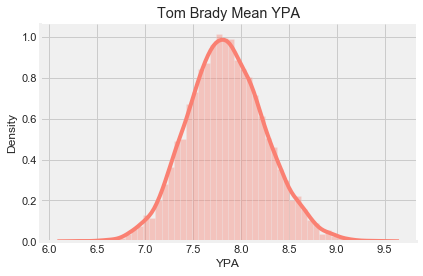

In [132]:
ax = sns.distplot(brady_bootstrap, color='salmon')
ax.set(xlabel='YPA', ylabel='Density', title='Tom Brady Mean YPA')
sns.despine();

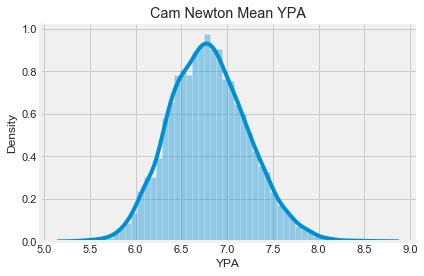

In [134]:
ax = sns.distplot(newton_bootstrap)
ax.set(xlabel='YPA', ylabel='Density', title='Cam Newton Mean YPA')
sns.despine();

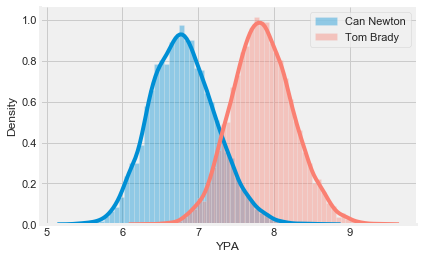

In [133]:
ax = sns.distplot(newton_bootstrap, label='Can Newton')
ax = sns.distplot(brady_bootstrap, label='Tom Brady', ax=ax, color='salmon')
ax.set(xlabel='YPA', ylabel='Density')
sns.despine()
plt.legend();

So Brady throws more per pass attempt than Newton. Which of the two quarterback's posterior distribution is shorter (which indicates that there is more uncertainty)? It looks to me that Brady is slightly more predictable.

In [142]:
# calculate the posterior for the difference between Brady's and Newton's YPA
ypa_diff = np.array(brady_bootstrap) - np.array(newton_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [143]:
# the mean of the posterior
ypa_diff.mean()

1.0490583873514434

So it looks like about 105% of the distribution is greater than 0, which give us confidence that Brady's mean YPA was greater than Newton's.

We can actually calculate the probability that Brady's mean YPA was greater than Newton's mean YPA by measuring the proportion of values greater than 0 in the above distribution.

In [144]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.9622

## Comparing other quarterbacks

In addition, we can use the Bayesian bootstrap to compare other QBs.

In [145]:
# league average ypa as a comparison point
ypa = qb_pass_df.Yards_Gained.sum() / qb_pass_df.Yards_Gained.size

In [135]:
# Creat a list of QBs we are interested in comparing
players = ['Tom Brady', 'Cam Newton', 'Jimmy Garoppolo', 'Drew Brees', 
           'Deshaun Watson', 'Derek Carr', 'Eli Manning', 'Russell Wilson', 
           'Dak Prescott', 'Aaron Rodgers']

# Grab their passes from our data
select_players = qb_pass_df.loc[qb_pass_df.Player.isin(players)]
# make sure that each player only has one unique id
select_players.groupby(['Player', 'GSIS_ID']).size()

Player           GSIS_ID   
Aaron Rodgers    00-0023459    238
Cam Newton       00-0027939    490
Dak Prescott     00-0033077    488
Derek Carr       00-0031280    515
Deshaun Watson   00-0033537    202
Drew Brees       00-0020531    534
Eli Manning      00-0022803    571
Jimmy Garoppolo  00-0031345    176
Russell Wilson   00-0029263    551
Tom Brady        00-0019596    580
dtype: int64

In [136]:
# this is a helper function that we can use to create our bayesian booststrap
# samples for each player, calculate the HDI a
def create_bb_ypa_df(group, n_replications=10000, alpha=0.05,
                     col='Yards_Gained'):
    # construct the posterior
    posterior = bb.mean(group[col], n_replications=n_replications)
    # construct HDI
    lower_ci, upper_ci = bb.highest_density_interval(posterior, alpha=0.05)
    # get the players observed YPA
    pass_yards = group[col].sum()
    pass_attempts = len(group[col])
    mean_ypa = pass_yards / pass_attempts
    # the data we want
    data = pd.Series({'posterior': posterior,
                      'lower_ci': lower_ci,
                      'upper_ci': upper_ci,
                      
                      # these will make constructing the plot to to compare
                      # the players 95% HDI easier
                      'lower_ci_diff': lower_ci - mean_ypa,
                      'upper_ci_diff': upper_ci - mean_ypa,
                      'est_mean_ypa': np.mean(posterior),
                      'pass_attempts': pass_attempts,
                      'pass_yards': pass_yards,
                      'obs_mean_ypa': mean_ypa})
    return data

In [137]:
# construct posteriors for each player by grouping by each player and applying
# the above helper function
# we should get a dataframe with each player's info
with NumpyRNGContext(42):
    ypa_df = (select_players.groupby(['GSIS_ID', 'Player'])
                            .apply(create_bb_ypa_df)
                            .reset_index())

In [138]:
# take a look at the dataframe
ypa_df

GSIS_ID           Player  \
0  00-0019596        Tom Brady   
1  00-0020531       Drew Brees   
2  00-0022803      Eli Manning   
3  00-0023459    Aaron Rodgers   
4  00-0027939       Cam Newton   
5  00-0029263   Russell Wilson   
6  00-0031280       Derek Carr   
7  00-0031345  Jimmy Garoppolo   
8  00-0033077     Dak Prescott   
9  00-0033537   Deshaun Watson   

                                           posterior  lower_ci   upper_ci  \
0  [8.046542316667479, 8.08747301670763, 7.484759...  7.098647   8.688022   
1  [8.251561109388554, 8.291046853326547, 8.10128...  7.385702   9.075398   
2  [6.252234662549597, 6.073114719359971, 6.46561...  5.486096   6.860067   
3  [7.286371256624172, 6.860856743754333, 7.82831...  5.801599   8.307189   
4  [6.88060530274515, 6.923823283885138, 6.695280...  5.948433   7.613515   
5  [6.670797698337258, 7.513291467017578, 6.96840...  6.450917   8.184603   
6  [6.625293037256027, 7.192416955835589, 7.40003...  6.012689   7.734327   
7  [8.731374719492056, 8.906528346320602, 7.70541...  7.353848  10.479067   
8  [6.786313472265736, 6.894882008326474, 6.44887...  6.058065   7.854200   
9  [9.504592538760377, 8.371361678110057, 8.76661...  6.912567   9.996847   

   lower_ci_diff  upper_ci_diff  est_mean_ypa  pass_attempts  pass_yards  \
0      -0.753077       0.836298      7.848041            580        4554   
1      -0.810928       0.878769      8.187418            534        4377   
2      -0.650507       0.723465      6.127814            571        3504   
3      -1.202603       1.302987      6.999593            238        1667   
4      -0.849526       0.815555      6.794905            490        3331   
5      -0.848539       0.885148      7.287411            551        4022   
6      -0.824204       0.897434      6.835706            515        3521   
7      -1.509788       1.615430      8.863596            176        1560   
8      -0.837427       0.958708      6.898578            488        3365   
9      -1.498324       1.585956      8.412789            202        1699   

   obs_mean_ypa  
0      7.851724  
1      8.196629  
2      6.136602  
3      7.004202  
4      6.797959  
5      7.299456  
6      6.836893  
7      8.863636  
8      6.895492  
9      8.410891

We can create ridgeline plots to plot out the full posterior distribution for each player.

In [147]:
title = 'Measuring the Uncertainty of a \nQB\'s Passing Performance\n(2017)'

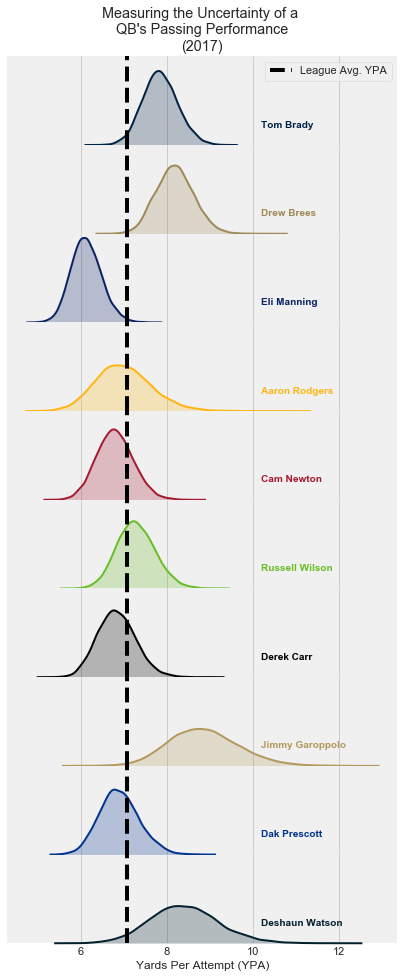

In [148]:
# explode list of psoteriors to make it easier to plot joy plot
# https://stackoverflow.com/questions/42012152/unstack-a-pandas-column-containing-lists-into-multiple-rows
ypa_posterior_df = pd.DataFrame({'Player': np.repeat(ypa_df.Player, 
                                                     ypa_df.posterior.str.len()),
                                 'posterior': np.concatenate(ypa_df.posterior.values)})

# this code is based on the code from the seaborn documentation
# https://seaborn.pydata.org/examples/kde_joyplot.html
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(.65, .2, label, fontweight="bold", color=color, 
            transform=ax.transAxes)

# use team colors for each player
tm_colors = ['#002244', '#9F8958', '#0B2265', '#FFB612', '#A71930', 
             '#69BE28', '#000000', '#B3995D', '#00338D', '#03202F']

# initialize the FacetGrid object
g = sns.FacetGrid(ypa_posterior_df, row="Player", hue="Player", aspect=4.5, 
                  size=1.3, palette=tm_colors)
# plot each player's posterior distribution
g.map(sns.kdeplot, "posterior", clip_on=False, shade=True, lw=2)
# label each distribution with the player's name
g.map(label, "posterior")
# add the the line representing the league avg YPA
g.map(plt.axvline, x=ypa, color='k', linestyle='--')
# Adjust the spacing for each player's kde plot so that they are veritcally 
# adjacent to one another
g.fig.subplots_adjust(hspace=0)
# # Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
# add legend, title and xlable
ax1 = g.axes[0, 0]
ax1.legend([ax1.lines[1]], ['League Avg. YPA'])
ax1.set_title(title)
plt.xlabel('Yards Per Attempt (YPA)');

We can also compare each player's posterior by plotting their 95% HDI like so below.

>*A High Density Interval (HDI) is an example of a Bayesian [Credible Interval](https://en.wikipedia.org/wiki/Credible_interval), which is a much better replacement for Frequentist statistics' [Confidence Interval](https://en.wikipedia.org/wiki/Confidence_interval) that is the theoretical long-run frequency (i.e., the proportion) of confidence intervals that contain the true value of the unknown population parameter). Doing frequentist statistics assumes you, the mathematician, as *God*, and you can observe all possible realities - that is why I don't like frequentists statistics. It's voodoo math and you can shape it to prove anything, for example that one race is somehow superior to another*.

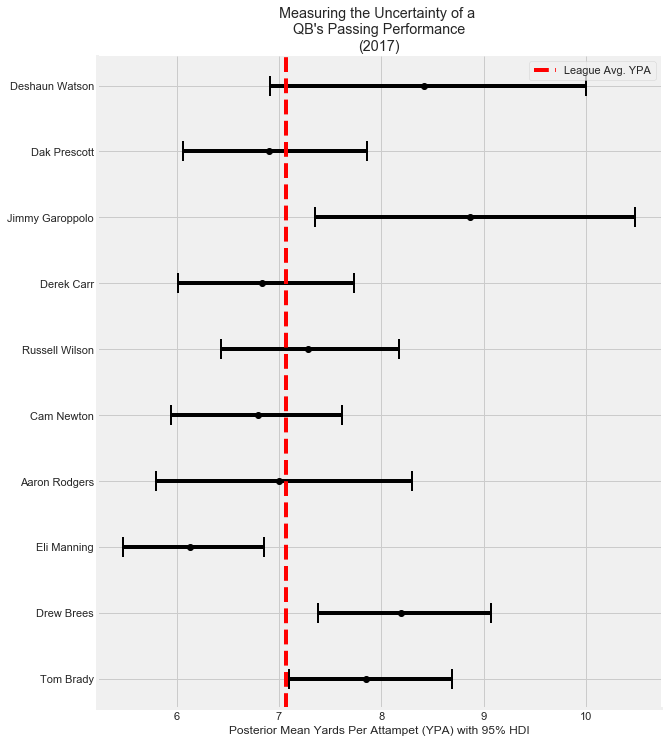

In [149]:
# in order to plot the HDI as error bars around a player's posterior mean
# we have to do this transformation of the data and pass it to 
# matplotlib's errorbar function parameter xerr
ypa_ci = np.array(list(zip(-ypa_df.lower_ci_diff, 
                            ypa_df.upper_ci_diff))).T

# now create the plot
plt.figure(figsize=(9,12))
plt.errorbar('est_mean_ypa', 'Player', xerr=ypa_ci, data=ypa_df, fmt='ko', 
             capthick=2, capsize=10, label=None)
plt.axvline(ypa, color='r', linestyle='--', label='League Avg. YPA')
plt.xlabel('Posterior Mean Yards Per Attampet (YPA) with 95% HDI')
title = 'Measuring the Uncertainty of a \nQB\'s Passing Performance\n(2017)'
plt.title(title)
plt.legend()
sns.despine();

You can compare other player positions, team by team, similarly, allowing you to build a team roster of player-by-player capability.

You have two weeks, good luck :-)

# References

- [ELO](https://github.com/fivethirtyeight/nfl-elo-game)
- [Pro-Football Reference](https://www.pro-football-reference.com/)
- [Ryurko's data](https://github.com/ryurko/nflscrapR-data)
- [Team rankings](https://www.teamrankings.com/nfl/player-stats/)
- [CBS Sports](https://www.cbssports.com/nfl/scoreboard/all/)
- [The Non-parametric Bootstrap as a Bayesian Model](http://sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/)